# Complete R117 Analysis,

In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import random
import powerlaw

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import scipy.stats as st
import scipy.optimize as spopt
import scipy.integrate as spint

from scipy.special import factorial
from scipy.stats import chi2,  ttest_ind, ks_2samp
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from astropy.time import Time
from tqdm import tqdm, trange
from matplotlib.patches import Rectangle

plt.style.use('default')

In [2]:
def powerlaw_wconst(x, parm):
    k = parm[0]
    c = parm[1]
    return c*x**(-k)

def calculate_goodness_of_fit(data, model):
    # Ensure that the data and model arrays have the same length
    if len(data) != len(model):
        raise ValueError("Data and model arrays must have the same length.")

    # Calculate the sum of squared differences (SSD) between data and model
    ssd = np.sum((data - model) ** 2)

    # Calculate the total sum of squares (TSS) of the data
    tss = np.sum((data - np.mean(data)) ** 2)

    # Calculate the coefficient of determination (R-squared)
    r_squared = 1 - (ssd / tss)

    return r_squared

def compare_distributions(hist1, hist2):
    # Perform Student's t-test
    statistic, p_value = ttest_ind(hist1, hist2)

    # Print the test results
    print("Student's t-test:")
    print("Statistic:", statistic)
    print("P-value:", p_value)
    
    
def compare_cdfs(cdf1, cdf2, x_cdf):
    # Perform Kolmogorov-Smirnov test
    statistic, p_value = ks_2samp(cdf1, cdf2)

    # Print the test results
    print("Kolmogorov-Smirnov test:")
    print("Statistic:", statistic)
    print("P-value:", p_value)
    
def redchisqg(ydata,ymod,dof,sd=None):  
    if sd==None:  
        chisq=np.sum((ydata-ymod)**2)  
    else:  
        chisq=np.sum(((ydata-ymod)/sd)**2 )   
    return chisq/dof

def fast_r117(csv_file):
    
    col = ['MJD','DM','DMError','Flux','FluxError','Width','PeakFrequency',\
             'PeakFrequencyError','BandWidth','BandWidthError','Fluence','FluenceError','Energy',\
             'RM','RMErrorLeft','RMErrorRight','Linear','LinearError','Circular','CircularError']
    fast_csv = pd.read_csv(csv_file, sep=",", skiprows=2, header=None, index_col=0, na_values='NA', \
                           names=col)
    
    fluence=fast_csv['Fluence'].values
    return fluence

def get_poisson_error(r, conf_level=0.68):
    """
    adapted from Gehrels et al. 1986
    example use:
    rate = np.array([1,2,3,10])
    get_poisson_error(rate, conf_level=0.68) # returns 1-sigma lower and upper limit on the rate
    
    can be used to get the lower and upper limits for burst rate. 
    If bursts_obserrved = 0, it becomes a one sided distrubution, wherein conf_level_onesided = 1 - (1-conf_level)*2 
    """
    low_lim = 0.5 * chi2.ppf((1 - conf_level) / 2, 2 * r)
    low_lim[np.isnan(low_lim)] = 0 
    upp_lim = 0.5 * chi2.ppf((1 + conf_level) / 2, 2 * (r+1))
    upp_lim[np.isnan(upp_lim)] = 0
    
    return low_lim, upp_lim

def simple_log_normal(x, mu, sigma, constant):
    return constant*((1)/(x*sigma*(2*np.pi)**0.5)) * np.exp(-((np.log(x) - mu)**2/(2*sigma**2)))

def poisson_distribution(x, lambda_, constant):
    return constant * (np.exp(-lambda_) * np.power(lambda_, x)) / factorial(x)

def log_normal(x, parm):
    mu = parm[0]
    sigma = parm[1]
    constant = parm[2]
    return constant*((1)/(x*sigma*(2*np.pi)**0.5)) * np.exp(-((np.log(x) - mu)**2/(2*sigma**2)))

def normal(x, parm):
    mu = parm[0]
    sigma = parm[1]
    constant = parm[2]
    return constant*((1)/(sigma*(2*np.pi)**0.5)) * np.exp(-0.5*((x - mu)/(sigma))**2)

def double_log_normal(x, parm):
    mu = parm[0]
    sigma = parm[1]
    constant = parm[2]
    mu2 = parm[3]
    sigma2 = parm[4]
    constant2 = parm[5]
    return constant*((1)/(x*sigma*(2*np.pi)**0.5)) * np.exp(-((np.log(x) - mu)**2/(2*sigma**2))) + constant2*((1)/(x*sigma2*(2*np.pi)**0.5)) * np.exp(-((np.log(x) - mu2)**2/(2*sigma2**2)))

def model_int_cf(ecent, ebins, model, *parm):
    '''General function for integrating the input model over energy bins ebins within curve_fit.
       Inputs:
           ecent - energy bin centres, dummy array with length len(ebins)-1 to fool curve_fit into 
                   accepting the function as the correct format for curve_fit.
           ebins - energy bin edges.
           model, parm - the curve_fit model name and input parameter list.
       Outputs:
           ymod - calculated counts-density model values for y-axis.'''
    i = 0
    ymod = np.zeros(len(ecent))
    for energy in ebins[:-1]:
        ymod[i], ymoderr = spint.quad(lambda x: model(x, parm),ebins[i],ebins[i+1])
        ymod[i] = ymod[i]/(ebins[i+1]-ebins[i])  # we now divide by the bin width to match the counts density
        # units of our data
        i=i+1
    return ymod

def histrebin(mininbin,counts,edges):
    '''Takes as input a minimum counts per bin and a histogram counts and bin edges, and combines 
       adjacent histogram bins as needed so that no bin has less than the required minimum.
       Inputs:
           mininbin - required minimum counts/bin.
           counts, edges - input histogram counts/bin and bin edges arrays.
       Outputs:
           counts2, edges2 - rebinned counts/bin and bin edges arrays'''
    
    edges2=np.zeros(1)
    counts2=np.zeros(1)
    i=0
    countsum=0
    firstbin_flag = 1
    edges2[0]=edges[0]
    
    for x in counts:
        countsum=countsum+x
        i=i+1
        if countsum >= mininbin and (sum(counts[i:]) >= mininbin or i == len(counts)):  # The sum over counts in 
            # remaining bins ensures that we are not left with a bin with counts less than our limit at the end.
            if firstbin_flag == 1: # if this is the first bin satisfying our requirement, 
                # do not append but replace bin 0 with countsum
                counts2[0]=countsum
                firstbin_flag = 0 # now we read the first bin we can switch this off
            else:
                counts2=np.append(counts2,countsum)
            edges2=np.append(edges2,edges[i])
            countsum=0        
            
    return counts2, edges2

def plot_spec_model(ebins,cdens,cdens_err,cdens_model, ml_cfpars, name):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    
    color_list = ['blue', 'orange', 'green', 'red', 'yellow']
    energies = (ebins[1:]+ebins[:-1])/2
    
    bwidths = np.diff(ebins)
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,9),sharex=True,gridspec_kw={'height_ratios':[2,1]})
    fig.subplots_adjust(hspace=0)
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', color = 'navy', label='Bin values')
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, weights = cdens_model, density= False, color = 'crimson', histtype='step', label='Log-normal')
    
    minchisq = np.sum(((cdens-log_normal(energies,ml_cfpars))/cdens_err)**2)
    dof = len(energies)-len(ml_cfpars)

    print("Minimum Chi-squared = "+str(minchisq)+" for "+str(dof)+" d.o.f. should not exceed "+str(st.chi2.ppf(1-.05, df=dof)))
    print("The goodness of fit is: ",st.chi2.sf(minchisq,df=dof))
    print("Reduced Chi-squared= "+str(minchisq/dof)+" for "+str(dof)+" d.o.f")
    
    ax2.errorbar(energies, cdens-cdens_model, xerr=bwidths/2., yerr=cdens_err, color = 'navy', fmt='.', label ='Bin values')
    ax2.axhline(1.0, color='crimson', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax2.set_xlabel('{}'.format(name) , fontsize = 20)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax1.set_ylabel('Normalised events/bin', fontsize = 20)
    ax2.set_ylabel('Data-model', fontsize = 15)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.set_yticks([-100, 0, 100])
    ax2.tick_params(labelsize=14)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax1.legend(prop={'size':15})
#     plt.savefig('{}_hist.pdf'.format(name), bbox_inches = 'tight')
    
    return energies, (np.abs(cdens/cdens_model-1)/(cdens_err/cdens_model))
    
def plot_fit(model, p0, var_dict, counts2, edges2, bwidths, cdens, cdens_err, energies, plot, name):
    """ calculates and prints the MLEs for the parameters, 
        plots the fit as a histogram through the binned data,
        calculates and prints the minimum chi^2 and the goodness of fit
    :param model: the curve_fit model name
    :param p0: the initial guesses for the parameters
    :param var_dict: a dictionary of the variable names of the parameters
    :param counts2: the rebinned count array
    :param edges2: the rebinned edge array
    :param bwidths: bin width
    :param cdens: count density array of each bin
    :param cdens_err: count density error array of each bin
    :param energies: energy value array of the points
    :return: the values and their positions with larger deviations from the model than 2 sigma
    """
    
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, model, *parm),
                                            energies, cdens, p0, sigma=cdens_err, maxfev = 8000)
    print(list(np.diagonal(ml_cfcovar)))
    #use the covariance matrix to find the errors
    err = np.sqrt(np.diag(ml_cfcovar)) 

    best_model = model_int_cf(energies, edges2, model, *ml_cfpars)
    
    #plots the model and returns the energy of each point and its error bar
    if plot:
        energies_of_points, error_bar_from_model = plot_spec_model(edges2,cdens,cdens_err,best_model, ml_cfpars, name)
    
#     #prints the found MLEs
#     for i in range(len(p0)):
#         print("Variable {} = ".format(var_dict[i]) + str(ml_cfpars[i]) + " +/- " + str(err[i]))
    
    minchisq = np.sum(((cdens-model(energies,ml_cfpars))/cdens_err)**2)
    dof = len(energies)-len(p0)
    
    return ml_cfpars, best_model, err, minchisq, edges2,cdens,cdens_err,best_model, energies_of_points

def fit_gaussian_to_dataset(dataset, bins, name, plot=True):
    """ plots the data into rebinned bins
        fits and plots a straight power-law model to the rebinned data
        fits and plots a straight power-law model plus a gaussian line feature to the rebinned data
    :param dataset: the input data to be rebinned and fitted 
    :param location: a guess of the location of the gaussian line feature
    :return ml_cfpars: the MLEs of the parameters
    :return err: the errors on the MLE of the parameters
    :return minchisq_pl: the minimum chi-squared for the single power-law model
    :return minchisq_pl_gaus: the minimum chi-squared for the power-law + gaussian model
    """ 
    hist, bins, = np.histogram(dataset, bins=bins, density=False)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    counts, edges = np.histogram(dataset, bins=logbins, density=False)
    
    #rebin the data into different bins and counts
    mincounts = 3
    counts2, edges2 = histrebin(mincounts,counts,edges)
    energies = (edges2[:-1]+edges2[1:])/2.
    
    bwidths = np.diff(np.log(edges2)) 
    cdens = counts2/bwidths 
    cdens_err = np.sqrt(counts2)/bwidths 

    #fit the continuum power-law model plus the gaussian to the data
    ml_cfpars, best_model, err, minchisq_pl,ebins,cdens,cdens_err,cdens_model, energies_of_points = plot_fit(log_normal, [5, 1.4, 25000], {0:'Noise Offset', 1:'N0', 2:'Lambda'}, counts2, edges2, bwidths, cdens, cdens_err, energies, plot, name)    
#     ml_cfpars, best_model, err, minchisq_pl,ebins,cdens,cdens_err,cdens_model, energies_of_points = plot_fit(log_normal, [5, 1.4, 25000, 0.001, 1.2, 1000], {0:'Noise Offset', 1:'N0', 2:'Lambda'}, counts2, edges2, bwidths, cdens, cdens_err, energies, plot)    
    print(list(ml_cfpars))
    
    if len(ml_cfpars) > 4:
        return np.exp(ml_cfpars[0] - ml_cfpars[1]**2), np.exp(ml_cfpars[3] - ml_cfpars[4]**2), energies_of_points, cdens, cdens_err
    else:
         return np.exp(ml_cfpars[0] - ml_cfpars[1]**2), energies_of_points, cdens, cdens_err

def kde_applied(input_data_array, bb = []):
    if len(bb) == 0:
        hist1, bins1 = np.histogram(input_data_array, bins=40)
        logbins1 = np.logspace(np.log10(bins1[0]),np.log10(np.ceil(bins1[-1])),len(bins1))

        hist1, bins= np.histogram(input_data_array, bins = logbins1)
    else:
        logbins1 = bb
        hist1, bins= np.histogram(input_data_array, bins = logbins1)
        
    xdata = np.log10(((bins+np.roll(bins, 1))/2)[1:])
    ydata = hist1

    x_test = xdata[:, np.newaxis]
    x_train = np.log10(input_data_array)[:, np.newaxis]

    bandwidth = np.linspace(0,0.2,50)
    kde = KernelDensity(kernel='gaussian')
    grid = GridSearchCV(kde, {'bandwidth': bandwidth})
    grid.fit(x_train)
    kde = grid.best_estimator_
    log_dens = kde.score_samples(x_test)

    total_value = 1e15
    factor_increase = np.linspace(0,100, 2000)

    for i in range(len(factor_increase)):
        total = sum(np.abs((ydata)-factor_increase[i]*np.exp(log_dens)))
        if total < total_value:
            total_value  =total
            best_fit_factor = factor_increase[i]

    return xdata,ydata,x_test,best_fit_factor*np.exp(log_dens), logbins1

def slope_est(energies_array):
    "Function to do a first order estimate of the slope and error"
    "This method comes from Dante and an older paper, see his slack and paper he mentions"

    energies_array.sort()
    M=len(energies_array)
    si=np.array(energies_array)/energies_array[0]

    corrfact=(M-1)/M
    a_star=corrfact*1/( (-1/M) * np.sum(np.log(si)) )
    err= M*a_star / ( (M-1)*(M-2)**0.5 )

    return a_star,err

def func_powerlaw(x, scale=1, gamma=1):
    return x**gamma * scale

def isotropic_energies(fluences, distance=360.86):
    "Convert list of fluences to spectral densities"
    "Method based on fluence.py by K.Nimmo"

    #convert from jyms to jys
    fluence_jys = np.array(fluences) * 1e-3

    #mpc to cm
    distance_lum_cm = 3.086e24*distance

    #redshift correction, see evernote for details
    z = 0.0771
    red_cor = 1 / (1 + z)**2

    energy_iso = fluence_jys * 4*np.pi*(distance_lum_cm**2) * 1e-23 * red_cor
    #print(energy_iso)

    return energy_iso

def all_omar_knowledge(fluence, obs_hours, scale_var):
    
    sorted_energy = isotropic_energies(fluence)
    
    sorted_energy = np.flip(sorted(sorted_energy))
    
#     sorted_energy = np.flip(np.sort(energy_iso))
    cum_rate = np.array(range(1,len(sorted_energy)+1))/obs_hours

    pw_results = powerlaw.Fit(sorted_energy)

    sorted_energy_fit = sorted_energy[sorted_energy >= pw_results.xmin]
    cum_rate_fit = cum_rate[sorted_energy >= pw_results.xmin]

    a_star, a_err = slope_est(sorted_energy_fit)
    popt, pcov = spopt.curve_fit(func_powerlaw, sorted_energy_fit, np.flip(cum_rate_fit),
                                   p0 = np.asarray([scale_var, a_star]), maxfev = 50000)

    #flip x and y to use the x-error
    popt_flip, pcov_flip = spopt.curve_fit(func_powerlaw, np.flip(cum_rate_fit),sorted_energy_fit,
                                     p0=[popt[0]**(1./-popt[1]), 1./popt[1]],
                                     sigma=np.asarray(sorted_energy_fit*0.2),\
                                     absolute_sigma=True)

    print(popt)

    popt_back=[popt_flip[0]**(1./-popt_flip[1]), 1./popt_flip[1]]
    sol2 = [popt_back, pcov_flip]
    sol2_err = np.sqrt(np.diag(sol2[1]))

    ##Bootstrapping
    subset_int = int(len(sorted_energy_fit) * 0.9)
    print(f"Bootstrapping, only using {subset_int} points out of {len(sorted_energy_fit)} points")

    N=1000
    alpha_list = []
    for trial in range(N):

        #subset_list = random.sample(list(energies_fit), k = subset_int)

        #Get a random sample of 90% from the fitted energies
        ss_energie, ss_ypoint = zip(*random.sample(list(zip(sorted_energy_fit, cum_rate_fit)),
                                                   k=subset_int))

        #Sort them again from big to small
        ss_energie_1, ss_ypoint_1 = zip(*sorted(zip(ss_energie, ss_ypoint)))
        popt_bs_yx, pcov_bs_yx=spopt.curve_fit(func_powerlaw,np.flip(ss_ypoint_1),ss_energie_1,
                                         p0=[popt[0]**(1./-popt[1]),1./popt[1]],
                                         sigma=np.asarray(ss_energie_1)*0.2,absolute_sigma=True)

        #Covert back to values, bootstramp reversed
        popt_bs_r=[popt_bs_yx[0]**(1./-popt_bs_yx[1]),1./popt_bs_yx[1]]

        #Append the value for the slope the list
        alpha_list.append(popt_bs_r[1])

    #Calculate the boot_alpha
    boot_alpha = np.std(alpha_list)

    return sorted_energy, cum_rate, sorted_energy_fit, sol2, sol2_err, boot_alpha, pw_results.xmin

def fluence_limit(sefd=420, width=1, bw=100, snr=20):
    '''
    sefd in Jy, width in ms, bw in MHz
    '''
    fluence_limit = snr * sefd * np.sqrt( (width/1000.) / (2 * bw * 1e6))
    # return things in Jy~ms
    return fluence_limit * 1000

def fluence_looper(df_fluence):
    "function to sum over the components returns the burst id and fluences in a pd df"

    #the burst names to loop over
    exps = df_fluence['id'].unique()

    #Create a list with the telescope names for easy filtering later on
    exps_tel = [i.split('-')[1] for i in exps]

    #loop over every burst to sum the fluence
    fluence_list = []
    for exp in exps:
        fluence_df_exp_temp = df_fluence[df_fluence['id'] == exp]
        fluence = sum(fluence_df_exp_temp['fluence_jyms'].values)
        fluence_list.append(fluence)

    #Convert the fluence list to array
    fluence_array = np.asarray(fluence_list)

    #Convert the Fluences to dataframe
    new_data = {'id': exps, 'fluence': fluence_array, 'telescope': exps_tel}
    df_new_fluence = pd.DataFrame(data=new_data)

    return df_new_fluence

def load_df(file):
    "Load in the dataframe and return the fluences"

    #load in the file
    fluence_df = pd.read_pickle(file)
    fluence_df.sort_values(by=['id'])
    #display(fluence_df)
    ##Wb, On and Tr Fluences
    #Only take the spc fluences
    df_spc = fluence_df[fluence_df['src'] == 'spc']
    df_spc_short = fluence_looper(df_spc)
    
    ##Stk Fluences
    df_stk = fluence_df[fluence_df['dish']=='st']
    df_stk_short = fluence_looper(df_stk)

    #Combine the two
    df_combined = pd.concat([df_spc_short, df_stk_short], ignore_index=True)
    #display(df_combined)
    df_combined.sort_values(by=['id'])
    
    df_combined['burst-index'] = df_combined['id'].str.split('-').str[0].str[1:].astype(int)
    df_combined = df_combined.sort_values(by=['burst-index'])
    
    #Dropping the duplicate bursts:
    
    #In case there is overlap with Torun, drop Torun due to bad baseline
    #In case St/Wb overlap, drop the fainter burst
    tr_overlap = ["B07-tr","B13-tr","B15-tr","B16-tr","B37-tr"]
    st_overlap = ["B30-st","B53-st","B63-st","B64-st","B68-st","B69-st","B104-st","B107-st"]
    wb_overlap = ["B82-wb","B85-wb","B106-wb"]
    
    #date_excl = []
    overlaps = np.concatenate((tr_overlap, st_overlap, wb_overlap))

    df_combined = df_combined[~df_combined['id'].isin(overlaps)]
    display(df_combined)
    
    return df_combined

def fluences_arrays(df_fluences, telescope):
    "return Fluences arrays from different activity windows"

    #Westerbork
    fluences = df_fluences[df_fluences['telescope'] == telescope]
    fluences_arr = fluences['fluence'].values
    fluences_arr[::-1].sort()

    return fluences_arr

## Acquiring the data

In [3]:
burst_csv =  pd.read_csv('fixed_fluences.csv', low_memory=False)

display(burst_csv)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,lilo name,cand name,power top,power middle,power bottom,power factor,time width,...,model B Probability,model C Probability,model D Probability,model E Probability,model F Probability,model G Probability,model H Probability,FETCH prediction,bowtie prediction,Real Burst
0,0,0.0,0.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_0.12060...,0.090515,0.271799,0.315393,0.861779,2784,...,1.141243e-01,0.000566,9.950000e-05,1.110000e-05,5.950000e-07,8.330000e-08,2.540000e-09,False,False,NaN
1,1,1.0,1.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_2.67578...,0.225863,0.168229,0.147636,0.744826,2640,...,6.430000e-08,0.016453,5.930000e-05,1.020000e-10,5.000000e-15,1.390000e-14,3.570000e-15,False,False,NaN
2,2,2.0,2.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_4.31834...,0.021031,0.018754,0.009961,0.891732,1376,...,2.633540e-04,0.000004,4.900000e-06,1.580000e-05,1.160000e-07,1.920000e-07,7.830000e-08,False,False,NaN
3,3,3.0,3.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_10.1164...,0.033300,0.036183,0.032494,1.086576,2352,...,1.899141e-03,0.000017,8.820000e-07,1.700000e-08,7.860000e-06,1.520000e-07,3.300000e-05,False,False,NaN
4,4,4.0,4.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_16.0321...,0.178091,0.174038,0.102811,0.977245,112,...,4.990000e-06,0.000179,9.100000e-07,4.330000e-07,8.880000e-10,3.960000e-05,9.460000e-10,False,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34603,34603,33473.5,NaN,lilo_2x3_8bit,./cand_tstart_59870.876897277783_tcand_30.1810...,NaN,NaN,NaN,NaN,290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34604,34604,33675.5,NaN,lilo_1x1_8bit,./cand_tstart_59869.877662037034_tcand_38.6381...,NaN,NaN,NaN,NaN,1150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34605,34605,33883.5,NaN,lilo_1x4_8bit,./cand_tstart_59869.881828703699_tcand_38.4213...,NaN,NaN,NaN,NaN,860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34606,34606,34422.5,NaN,lilo_1x1_8bit,./cand_tstart_59867.901782407411_tcand_17.1152...,NaN,NaN,NaN,NaN,570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True


In [4]:
#set all values of Real Burst to False when not True
for i in trange(len(burst_csv)):
    if np.isnan(burst_csv['Real Burst'][i]):
        burst_csv.loc[i, ('Real Burst')] = False
        
display(burst_csv) 

100%|██████████████████████████████████████████████████████████████████████████| 34608/34608 [00:23<00:00, 1469.31it/s]


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,lilo name,cand name,power top,power middle,power bottom,power factor,time width,...,model B Probability,model C Probability,model D Probability,model E Probability,model F Probability,model G Probability,model H Probability,FETCH prediction,bowtie prediction,Real Burst
0,0,0.0,0.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_0.12060...,0.090515,0.271799,0.315393,0.861779,2784,...,1.141243e-01,0.000566,9.950000e-05,1.110000e-05,5.950000e-07,8.330000e-08,2.540000e-09,False,False,False
1,1,1.0,1.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_2.67578...,0.225863,0.168229,0.147636,0.744826,2640,...,6.430000e-08,0.016453,5.930000e-05,1.020000e-10,5.000000e-15,1.390000e-14,3.570000e-15,False,False,False
2,2,2.0,2.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_4.31834...,0.021031,0.018754,0.009961,0.891732,1376,...,2.633540e-04,0.000004,4.900000e-06,1.580000e-05,1.160000e-07,1.920000e-07,7.830000e-08,False,False,False
3,3,3.0,3.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_10.1164...,0.033300,0.036183,0.032494,1.086576,2352,...,1.899141e-03,0.000017,8.820000e-07,1.700000e-08,7.860000e-06,1.520000e-07,3.300000e-05,False,False,False
4,4,4.0,4.0,lilo_1x1_8bit,./cand_tstart_60054.365219907406_tcand_16.0321...,0.178091,0.174038,0.102811,0.977245,112,...,4.990000e-06,0.000179,9.100000e-07,4.330000e-07,8.880000e-10,3.960000e-05,9.460000e-10,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34603,34603,33473.5,NaN,lilo_2x3_8bit,./cand_tstart_59870.876897277783_tcand_30.1810...,NaN,NaN,NaN,NaN,290,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34604,34604,33675.5,NaN,lilo_1x1_8bit,./cand_tstart_59869.877662037034_tcand_38.6381...,NaN,NaN,NaN,NaN,1150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34605,34605,33883.5,NaN,lilo_1x4_8bit,./cand_tstart_59869.881828703699_tcand_38.4213...,NaN,NaN,NaN,NaN,860,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True
34606,34606,34422.5,NaN,lilo_1x1_8bit,./cand_tstart_59867.901782407411_tcand_17.1152...,NaN,NaN,NaN,NaN,570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,True


# R117 Property Analysis

### Temporal and Frequency widths

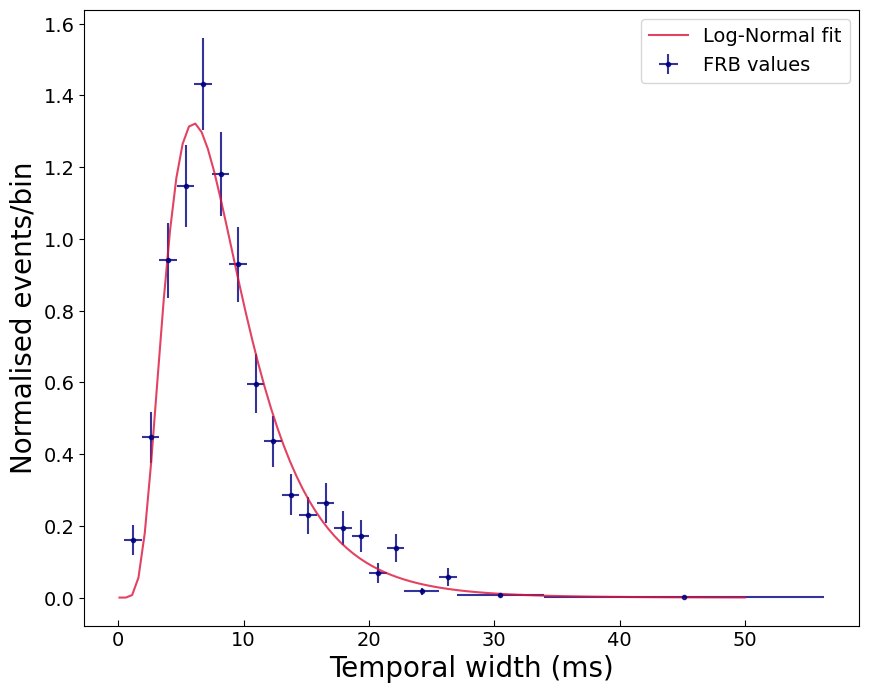

In [5]:
nbins = 40
counts, edges = np.histogram(np.array(burst_csv.query("`Real Burst` == True")['time width']), bins=nbins, density=False)

#rebin the data into different bins and counts
mincounts = 3
counts2, edges2 = histrebin(mincounts,counts,edges)

bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

color_list = ['blue', 'orange', 'green', 'red', 'yellow']

popt, pcov = spopt.curve_fit(simple_log_normal, energies*1.6e-2, cdens, maxfev = 50000)

fig = plt.figure(figsize=(10,8))
energies = (edges2[1:]+edges2[:-1])/2
bwidths = np.diff(edges2)

plt.errorbar(energies*1.6e-2, cdens, xerr=bwidths/2.*1.6e-2, yerr=cdens_err, fmt='.', label='FRB values', color='navy', alpha = 0.8)
plt.plot(np.linspace(0.1,50,100), simple_log_normal(np.linspace(0.1,50,100), *popt),  label='Log-Normal fit', color='crimson', alpha = 0.8)
plt.tick_params(labelsize=14)
plt.tick_params(axis="x",direction="in",which="both", length=4)
plt.ylabel('Normalised events/bin', fontsize = 20)
plt.xlabel('Temporal width (ms)', fontsize = 20)
plt.legend(prop={'size' : 14})
# plt.savefig('Time_width.pdf')
plt.show()

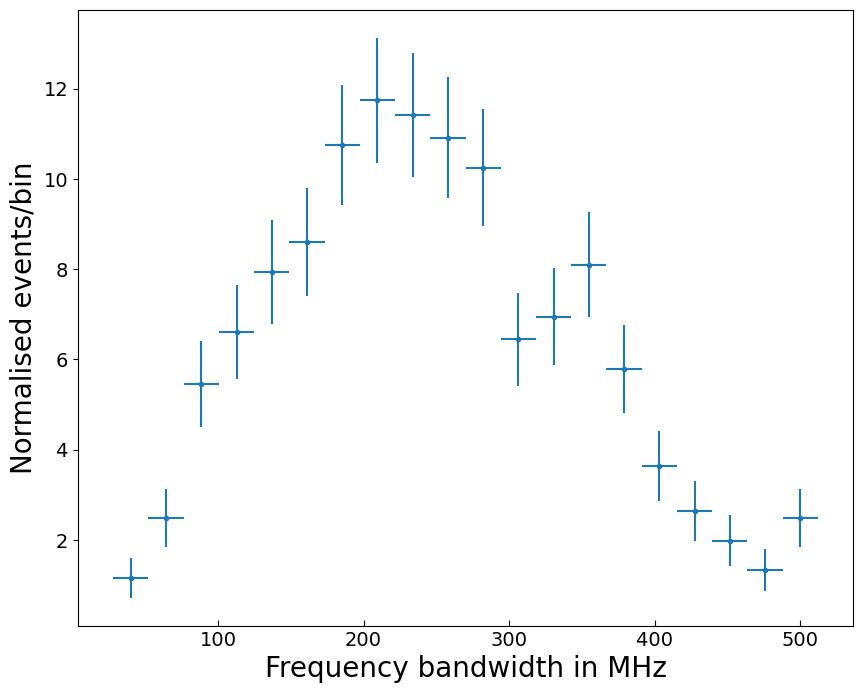

In [6]:
nbins = 20
counts_fwidth, edges_fwidth = np.histogram(np.array(burst_csv.query("`Real Burst` == True")['freq width']), bins=nbins, density=False)

#rebin the data into different bins and counts
mincounts = 3
counts2_fwidth, edges2_fwidth = histrebin(mincounts,counts_fwidth,edges_fwidth)

bwidths_fwidth = np.diff(edges2_fwidth) 
cdens_fwidth = counts2_fwidth/bwidths_fwidth
cdens_err_fwidth = np.sqrt(counts2_fwidth)/bwidths_fwidth 
energies_fwidth = (edges2_fwidth[:-1]+edges2_fwidth[1:])/2.

color_list = ['blue', 'orange', 'green', 'red', 'yellow']

fig = plt.figure(figsize=(10,8))
energies = (edges2_fwidth[1:]+edges2_fwidth[:-1])/2
bwidths = np.diff(edges2_fwidth)
# plt.axvline(x=4*np.mean(np.array(burst_csv[burst_csv['truth'] == True]['freq width'])),color='k',linewidth=2, linestyle='--')
plt.errorbar(4*energies_fwidth, cdens_fwidth, xerr=bwidths_fwidth/2.*4, yerr=cdens_err_fwidth, fmt='.', label='Bin values')
plt.tick_params(labelsize=14)
plt.tick_params(axis="x",direction="in",which="both", length=4)
plt.ylabel('Normalised events/bin', fontsize = 20)
plt.xlabel('Frequency bandwidth in MHz', fontsize = 20)
# plt.savefig('Freq_width.pdf')
plt.show()

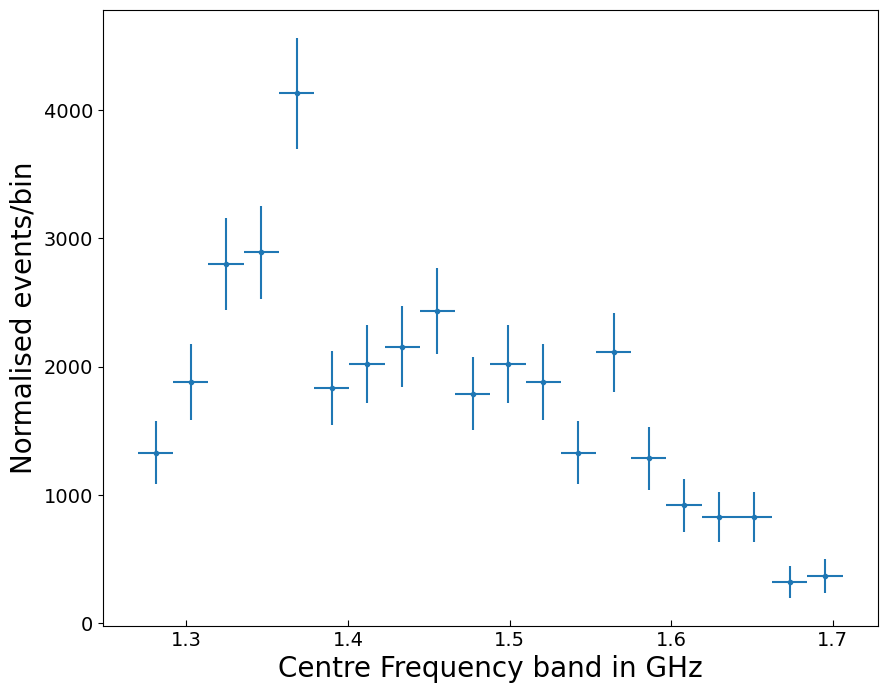

In [7]:
nbins = 20
counts_cfreq, edges_cfreq = np.histogram(np.array(burst_csv.query("`Real Burst` == True")['center frequency']), bins=nbins, density=False)

#rebin the data into different bins and counts
mincounts = 4
counts2_cfreq, edges2_cfreq = histrebin(mincounts,counts_cfreq,edges_cfreq)

bwidths_cfreq = np.diff(edges2_cfreq) 
cdens_cfreq = counts2_cfreq/bwidths_cfreq
cdens_err_cfreq = np.sqrt(counts2_cfreq)/bwidths_cfreq 
energies_cfreq = (edges2_cfreq[:-1]+edges2_cfreq[1:])/2.

color_list = ['blue', 'orange', 'green', 'red', 'yellow']

fig = plt.figure(figsize=(10,8))
energies = (edges2_cfreq[1:]+edges2_cfreq[:-1])/2
bwidths = np.diff(edges2_cfreq)
plt.errorbar(energies_cfreq, cdens_cfreq, xerr=bwidths_cfreq/2., yerr=cdens_err_cfreq, fmt='.', label='Bin values')
plt.tick_params(labelsize=14)
plt.tick_params(axis="x",direction="in",which="both", length=4)
plt.ylabel('Normalised events/bin', fontsize = 20)
plt.xlabel('Centre Frequency band in GHz', fontsize = 20)
# plt.savefig('Centrefrequency.pdf')
plt.show()

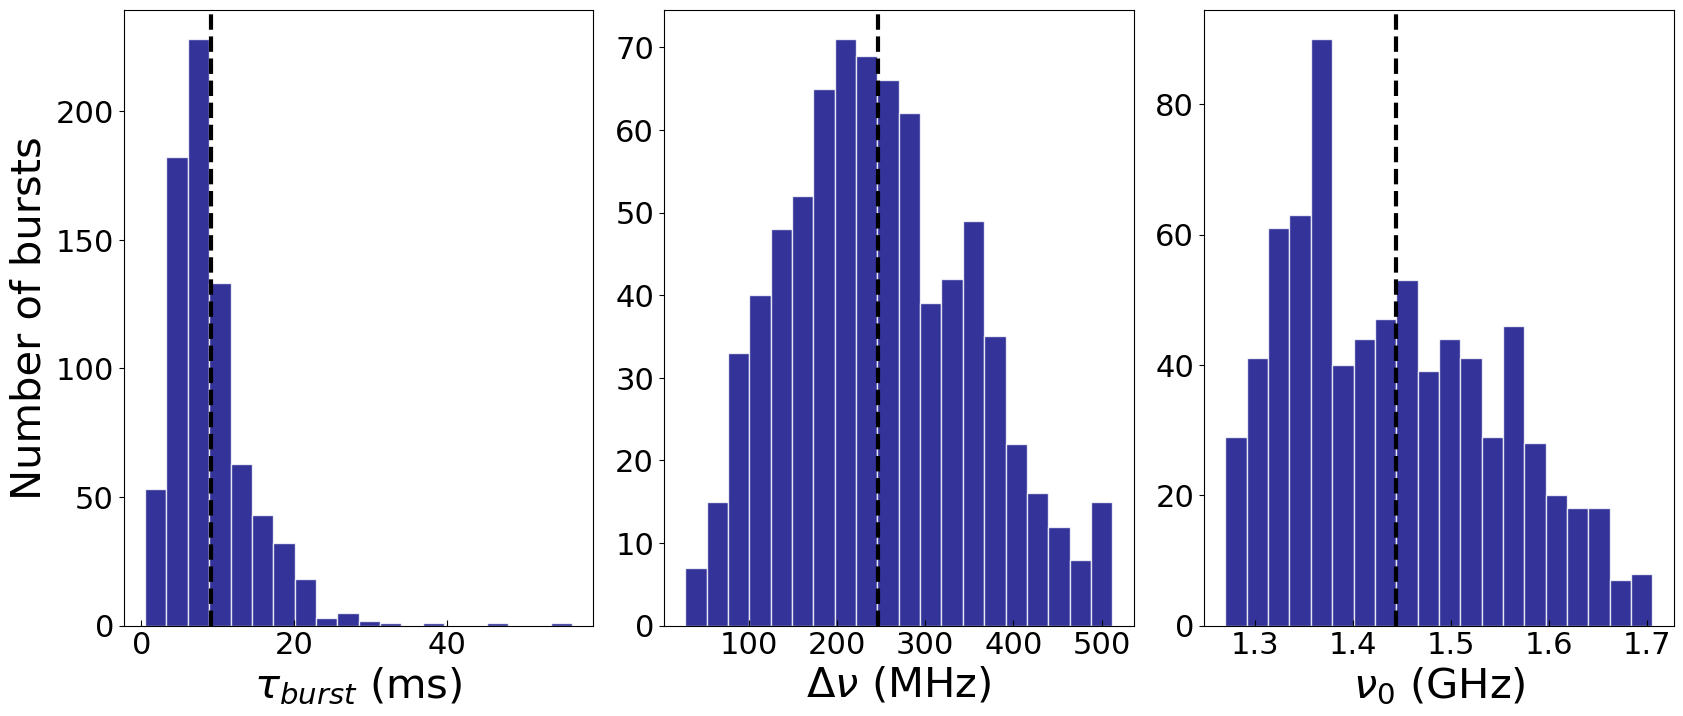

In [8]:
fig = plt.figure(figsize=(20, 8))
rows=1
cols=3
widths = [1,1,1]
heights = [1]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.15, hspace=0.0)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(1.6e-2*np.array(burst_csv.query("`Real Burst` == True")['time width']), bins = 20, alpha = 0.8, color= 'navy', edgecolor='white')
ax1.axvline(x=1.001*1.6e-2*np.mean(np.array(burst_csv[burst_csv['Real Burst'] == True]['time width'])), linewidth = 3, linestyle='--', color='k')
ax1.tick_params(labelsize=22)
ax1.tick_params(axis="x",direction="in",which="both", length=4)
ax1.set_ylabel('Number of bursts', fontsize = 30)
ax1.set_xlabel(r'$\tau_{burst}$ (ms)', fontsize = 30)

ax2 = fig.add_subplot(gs[0,1])
ax2.hist(np.array(burst_csv.query("`Real Burst` == True")['freq width'])*4, bins = 20, alpha = 0.8, color= 'navy', edgecolor='white')
ax2.axvline(x=0.99*4*np.mean(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])), linewidth = 3, linestyle='--', color='k')
ax2.tick_params(labelsize=22)
ax2.set_xticks([100, 200, 300, 400, 500])
ax2.tick_params(axis="x",direction="in",which="both", length=4)
ax2.set_xlabel(r'$\Delta \nu$ (MHz)', fontsize = 30)

ax3 = fig.add_subplot(gs[0,2])
ax3.hist(np.array(burst_csv.query("`Real Burst` == True")['center frequency']), bins = 20, alpha = 0.8, color= 'navy', edgecolor='white')
ax3.axvline(x=1.001*np.mean(np.array(burst_csv[burst_csv['Real Burst'] == True]['center frequency'])), linewidth = 3, linestyle='--', color='k')
ax3.tick_params(labelsize=22)
ax3.set_xticks([1.3, 1.4, 1.5, 1.6, 1.7])
ax3.tick_params(axis="x",direction="in",which="both", length=4)
ax3.set_xlabel(r'$\nu_0$ (GHz)', fontsize = 30)
# plt.savefig('Burstwidths.pdf', bbox_inches = 'tight')
plt.show()

[0.001675376400890785, 0.00043124496120217315, 732846.9389458331]
Minimum Chi-squared = 33.912127004263304 for 33 d.o.f. should not exceed 47.39988391908093
The goodness of fit is:  0.4233823296949137
Reduced Chi-squared= 1.0276402122504031 for 33 d.o.f
[3.4289897554921467, 0.7067080217074965, 17557.543979118942]


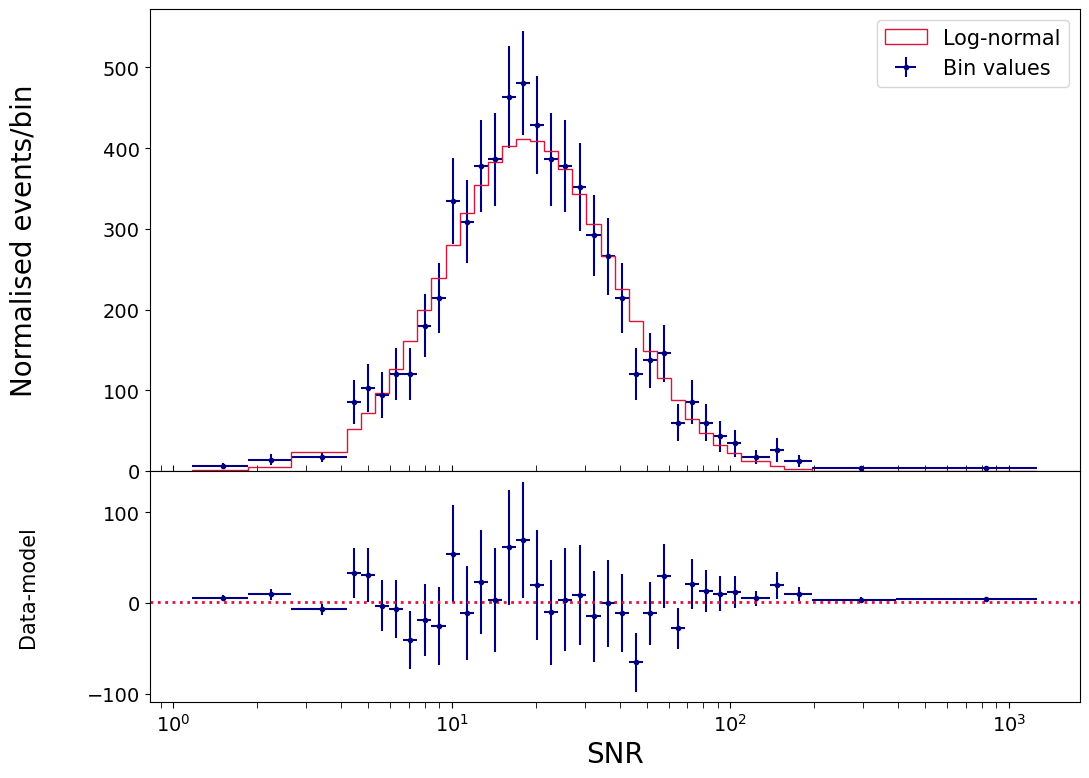

In [9]:
_ = fit_gaussian_to_dataset(np.array(burst_csv.query('`Real Burst` == True')['S/N']), 60, 'SNR', plot=True)

[0.002336480480083273, 0.0005754187282829532, 13951.3666610713]
Minimum Chi-squared = 40.293460013520544 for 33 d.o.f. should not exceed 47.39988391908093
The goodness of fit is:  0.1788395331994084
Reduced Chi-squared= 1.2210139398036528 for 33 d.o.f
[1.36727442113977, 0.7470297564694012, 2151.5067425423754]


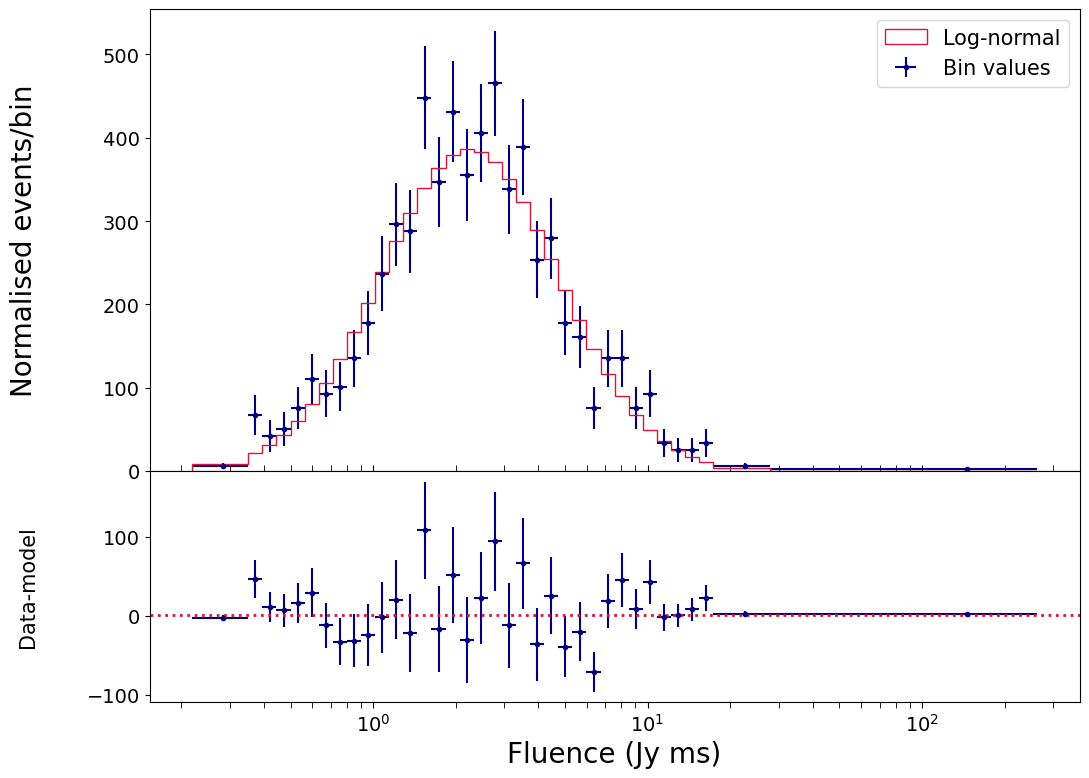

In [10]:
_ = fit_gaussian_to_dataset(np.array(burst_csv.query('`Real Burst` == True')['fluence']), 60, 'Fluence (Jy ms)', plot=True)

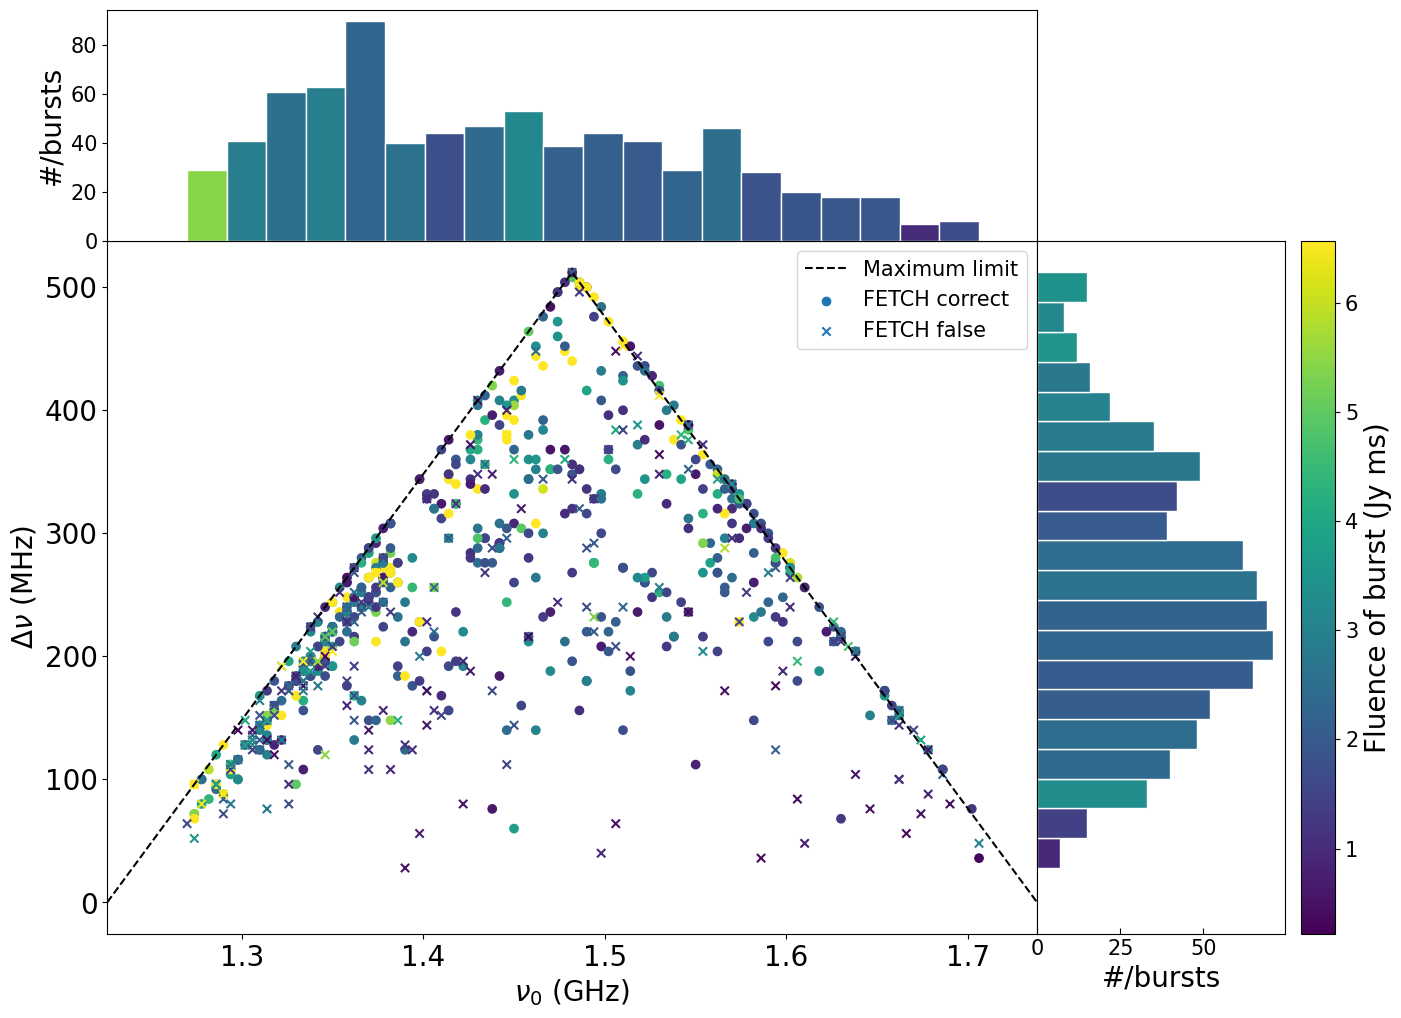

In [11]:
v0_total = np.array(burst_csv[burst_csv['Real Burst'] == True]['center frequency'])
dv_total = np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])*4
frb_fluence = []

for i in range(len(burst_csv[burst_csv['Real Burst'] == True])):
    frb_fluence.append(float(np.array(burst_csv[burst_csv['Real Burst'] == True]['fluence'])[i]))
    
v0_select=np.array(burst_csv.query('`Real Burst` == True & `freq width` > 25 & `center frequency` > 1.35 & `center frequency` < 1.6 ' )['center frequency'])
dv_select=np.array(burst_csv.query('`Real Burst` == True & `freq width` > 25 & `center frequency` > 1.35 & `center frequency` < 1.6 ' )['freq width'])*4

snr = np.array(frb_fluence)
cm = plt.cm.get_cmap('viridis')

fig = plt.figure(figsize=(16, 12))
rows=2
cols=2
widths = [3,1]
heights = [1,3]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

ax1 = fig.add_subplot(gs[1,0])

fetch_miss_list = [not elem for elem in np.array(burst_csv[burst_csv['Real Burst'] == True]['FETCH prediction'])]
fetch_correct_list = np.array(burst_csv[burst_csv['Real Burst'] == True]['FETCH prediction'])

sc = ax1.scatter(v0_total[fetch_correct_list], dv_total[fetch_correct_list], c=snr[fetch_correct_list], label= 'FETCH correct', marker = 'o', cmap='viridis', vmin=np.percentile(snr,0), vmax=np.percentile(snr,90))
sc1 = ax1.scatter(v0_total[fetch_miss_list], dv_total[fetch_miss_list], c=snr[fetch_miss_list], label = 'FETCH false',marker = 'x', cmap='viridis', vmin=np.percentile(snr,0), vmax=np.percentile(snr,90))

ax1.plot([1.226, 1.482, 1.738],[0, 128*4, 0], linestyle='--', c='k', label='Maximum limit')
ax1.set_xlabel(r'$\nu_0$ (GHz)', fontsize = 20)
ax1.set_ylabel(r'$\Delta \nu$ (MHz)', fontsize = 20)
ax1.legend(prop={'size':15})
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.set_xlim(1.226, 1.738)

ax2 = fig.add_subplot(gs[0,0], sharex=ax1)
values, bins, patches = ax2.hist(np.array(burst_csv[burst_csv['Real Burst'] == True]['center frequency']), bins = 20, color='#440154ff', edgecolor='white')

snr_bins = []
for j in range(len(bins)-1):
    snr_average = []
    for i in range(len(v0_total)):
        if v0_total[i] >= bins[j] and v0_total[i] <= bins[j+1]:
            snr_average.append(snr[i])
    snr_bins.append(np.median(snr_average))
    
for c, p in zip(snr_bins/np.percentile(snr, 90), patches):
    plt.setp(p, 'facecolor', cm(c))
    
ax2.tick_params(labelsize=14)
ax2.tick_params(axis="x",direction="in",which="both", length=4)
ax2.set_ylabel('#/bursts', fontsize = 20)
ax2.get_xaxis().set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=15)

ax3 = fig.add_subplot(gs[1,1], sharey=ax1)
values, bins, patches = ax3.hist(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])*4, bins = 20, color= '#440154ff', edgecolor='white', orientation='horizontal')

snr_bins = []
for j in range(len(bins)-1):
    snr_average = []
    for i in range(len(dv_total)):
        if dv_total[i] >= bins[j] and dv_total[i] <= bins[j+1]:
            snr_average.append(snr[i])

    snr_bins.append(np.median(snr_average))

for c, p in zip(snr_bins/np.percentile(snr, 90), patches):
    plt.setp(p, 'facecolor', cm(c))

ax3.tick_params(labelsize=14)
ax3.tick_params(axis="x",direction="in",which="both", length=4)
ax3.set_xlabel('#/bursts', fontsize = 20)
ax3.get_yaxis().set_visible(False)
ax3.tick_params(axis='both', which='major', labelsize=15)
cbar = fig.colorbar(sc)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_ylabel('Fluence of burst (Jy ms)', size =20)

# plt.savefig('FreqWidths_CentFreq_fluence.pdf', bbox_inches = 'tight')
plt.show()

In [12]:
frb_time = []
frb_freqcentre = []
frb_freqwidth = []

for i in range(len(burst_csv[burst_csv['Real Burst'] == True])):
    frb_time.append(float(np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[2]))
    frb_freqcentre.append(1000*float(np.array(burst_csv[burst_csv['Real Burst'] == True]['center frequency'])[i]))
    frb_freqwidth.append(4*float(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])[i]))

In [13]:
frb_freqbottom = np.rint(np.array(frb_freqcentre)-np.array(frb_freqwidth)/2)
frb_freqtop = np.rint(np.array(frb_freqcentre)+np.array(frb_freqwidth)/2)
obs_day_array = np.unique(np.array(frb_time, dtype=int))
bw_bursts = [np.zeros(129) for _ in range(len(obs_day_array))] 
total_bw_bursts = np.zeros(129)

#creates a list which shows the frequency extend of the burst in 0s and 1s, which can be added for multiple bursts
# for instance [0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0]
for i in range(len(frb_time)):
    bw_burst = bw_bursts[np.argwhere(obs_day_array == int(frb_time[i]))[0][0]]
    for j in range(129):
        freq_channel = 1226+j*4
        counter = 0
        if freq_channel >= frb_freqbottom[i]:
            counter += 1
        if freq_channel >= frb_freqtop[i]:
            counter += 1
        if counter == 1:
            bw_burst[j] += 1
            total_bw_bursts[j]+=1

In [14]:
total_possible_observing_days = np.linspace(59867, 60054, 188)
counter = 0
total_bursts_bws = []

#total number of bursts in band
for i in range(len(total_possible_observing_days)):
    if total_possible_observing_days[i] in obs_day_array:
        total_bursts_bws.append(bw_bursts[counter])
        counter += 1
    else:
        total_bursts_bws.append(np.zeros(129))

In [15]:
for i in range(len(total_bursts_bws)):
    for j in range(len(total_bursts_bws[i])):
        if total_bursts_bws[i][j] == 0:
            total_bursts_bws[i][j] = -2

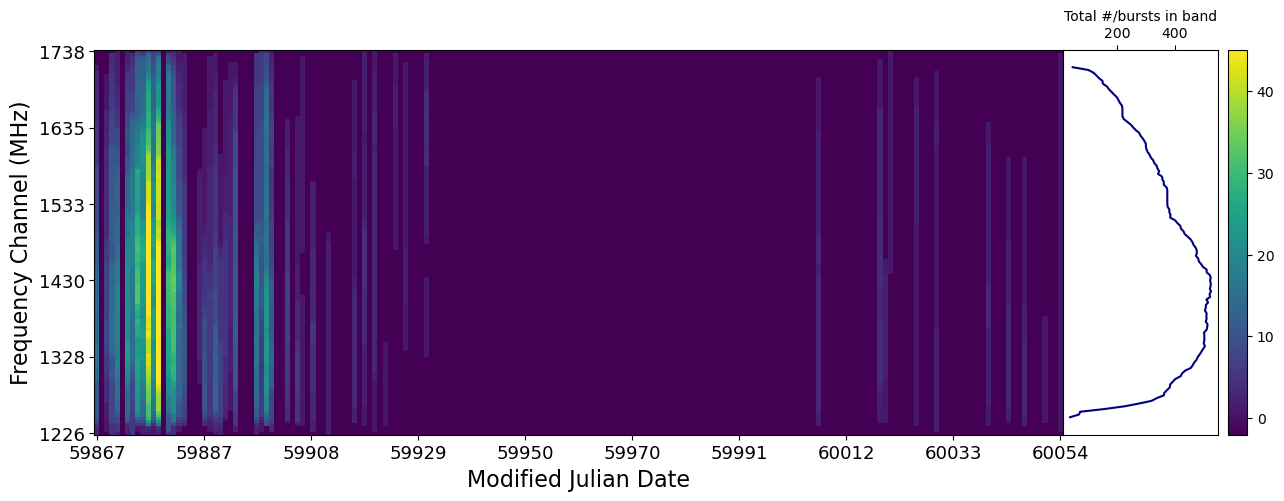

In [16]:
fig = plt.figure(figsize=(15, 5))
rows=1
cols=2
widths = [5,1]
heights = [1]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

ax1 = fig.add_subplot(gs[0,0])
clb = ax1.imshow(np.flip(np.array(total_bursts_bws).T, axis = 0),cmap = 'viridis', vmin = -2, vmax = 45, aspect='auto',interpolation='None')
ax1.set_xticks(np.linspace(0, 187, 10))
ax1.set_xticklabels(np.array(np.linspace(59867,60054, 10), int))
ax1.set_yticks(np.linspace(0, 128, 6))
ax1.set_yticklabels(np.array(np.linspace(1738, 1226, 6), int))
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_xlabel('Modified Julian Date', fontsize = 16)
ax1.set_ylabel('Frequency Channel (MHz)', fontsize = 16)

plt.style.use('default')
ax2 = fig.add_subplot(gs[0,1])
ax2.plot(total_bw_bursts, np.linspace(0, 128 ,129), label='Bin values', c='navy')
ax2.get_yaxis().set_visible(False)
ax2.xaxis.tick_top()
ax2.set_xlabel(('Total #/bursts in band'))
ax2.xaxis.set_label_position("top")
plt.colorbar(clb)
# plt.savefig('Colored_bandwidths_time.pdf', bbox_inches = 'tight')
plt.show()

 ### Wait Times

In [17]:
cand_ar = []
cand_full_ar = []
time_burst = []
cand_name = []

for i in trange(len(burst_csv[burst_csv['Real Burst'] == True])):
    cand_name.append(np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i])
    cand = np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[2][:5]
    canf_full = np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[2]
    time_burst.append(np.array(burst_csv[burst_csv['Real Burst'] == True]['cand name'])[i].split('_')[-5])
    cand_full_ar.append(canf_full)
    cand_ar.append(cand)
    
cand_ordered_full_ar = [[] for _ in range(len(np.unique(cand_ar)))]
time_burst_full = [[] for _ in range(len(np.unique(cand_ar)))]
cand_name_ordered = [[] for _ in range(len(np.unique(cand_ar)))]

#link each burst to the observation day and observation duration
for i in range(len(cand_ar)):
    for j in range(len(np.unique(cand_ar))):
        if np.unique(cand_ar)[j] == cand_ar[i]:
            cand_ordered_full_ar[j].append(cand_full_ar[i])
            time_burst_full[j].append(time_burst[i])
            cand_name_ordered[j].append(cand_name[i])

100%|████████████████████████████████████████████████████████████████████████████████| 766/766 [00:08<00:00, 87.40it/s]


In [18]:
full_time_in_seconds_for_each_candidate = [[] for _ in range(len(np.unique(cand_ar)))]

#for each burst find exactly at which date and time it was in YY:MM:DD format
for j in range(len(np.unique(cand_ar))):
    seconds_array = []
    first_burst = np.array(np.sort(cand_ordered_full_ar[j]).astype(float))[0]
    for i in range(len(cand_ordered_full_ar[j])):
        time_between = Time(np.array(cand_ordered_full_ar[j]).astype(float)[i] - first_burst, format='mjd').isot
        seconds_between = float(time_between.split(':')[-2])*60 + float(time_between.split(':')[-1]) + float(time_burst_full[j][i])
        full_time_in_seconds_for_each_candidate[j].append(seconds_between)

In [19]:
first_burst_fluence = []
second_burst_fluence = []

#for each burst pair within 0.5 seconds, find the fluence for the first and second burst
for i in range(len(full_time_in_seconds_for_each_candidate)):
    zipped_sorted = sorted(zip(full_time_in_seconds_for_each_candidate[i], np.arange(len(full_time_in_seconds_for_each_candidate[i]))), key=lambda x: x[0])
    for j in range(len(zipped_sorted) - 1):
        if (zipped_sorted[j+1][0] -  zipped_sorted[j][0]) < 0.5 and (zipped_sorted[j+1][0] -  zipped_sorted[j][0]) > 0:
            first_int = zipped_sorted[j][1]
            second_int = zipped_sorted[j+1][1]

            first_burst_total_index = [k for k, j in enumerate(cand_name) if j == cand_name_ordered[i][first_int]][0]
            second_burst_total_index = [k for k, j in enumerate(cand_name) if j == cand_name_ordered[i][second_int]][0]
            
            first_burst_fluence.append(frb_fluence[first_burst_total_index])
            second_burst_fluence.append(frb_fluence[second_burst_total_index])

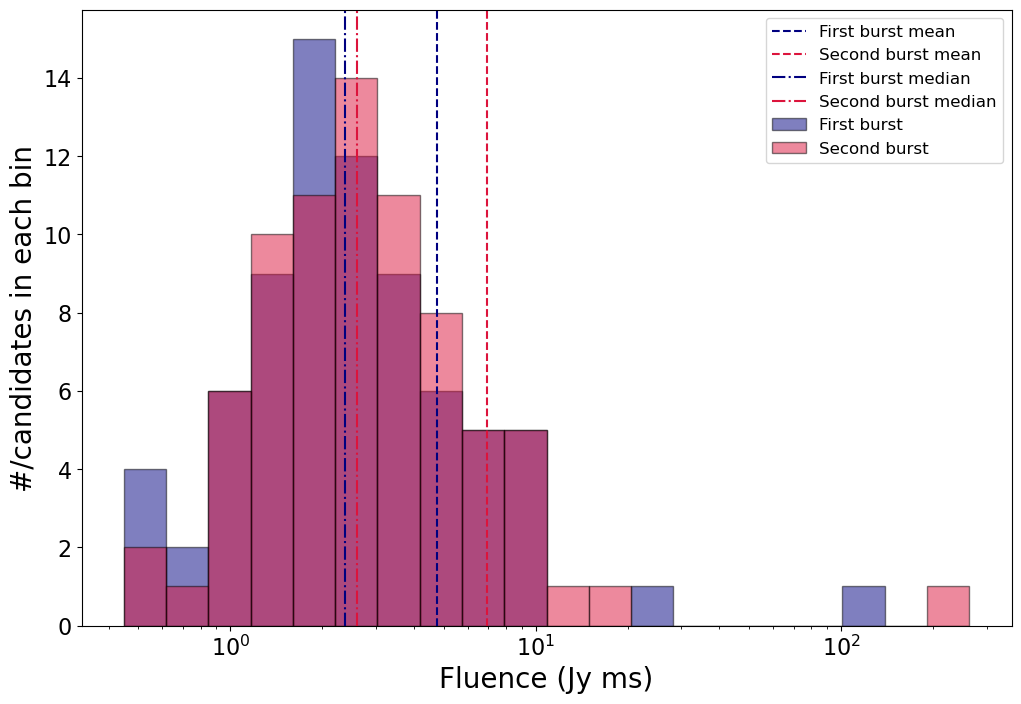

In [20]:
fig = plt.figure(figsize=(12, 8))

hist1, bins1 = np.histogram(second_burst_fluence, bins=20)
logbins = np.logspace(np.log10(bins1[0]),np.log10(np.ceil(bins1[-1])),len(bins1))

plt.hist(first_burst_fluence, bins = logbins, edgecolor = 'black', color = 'navy', alpha = 0.5, label='First burst')
plt.hist(second_burst_fluence,bins = logbins, edgecolor = 'black', color = 'crimson', alpha = 0.5, label='Second burst')
plt.axvline(x=np.mean(first_burst_fluence), linestyle='--',c='navy', label='First burst mean')
plt.axvline(x=np.mean(second_burst_fluence), linestyle='--',c='crimson', label='Second burst mean')
plt.axvline(x=np.median(first_burst_fluence), linestyle='-.',c='navy', label='First burst median')
plt.axvline(x=np.median(second_burst_fluence), linestyle='-.',c='crimson', label='Second burst median')
plt.xscale('log')
plt.xlabel('Fluence (Jy ms)', fontsize = 20)
plt.ylabel('#/candidates in each bin', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(prop={'size' : 12})
# plt.savefig('consecutive_burst_distribution.pdf', bbox_inches = 'tight')
plt.show()

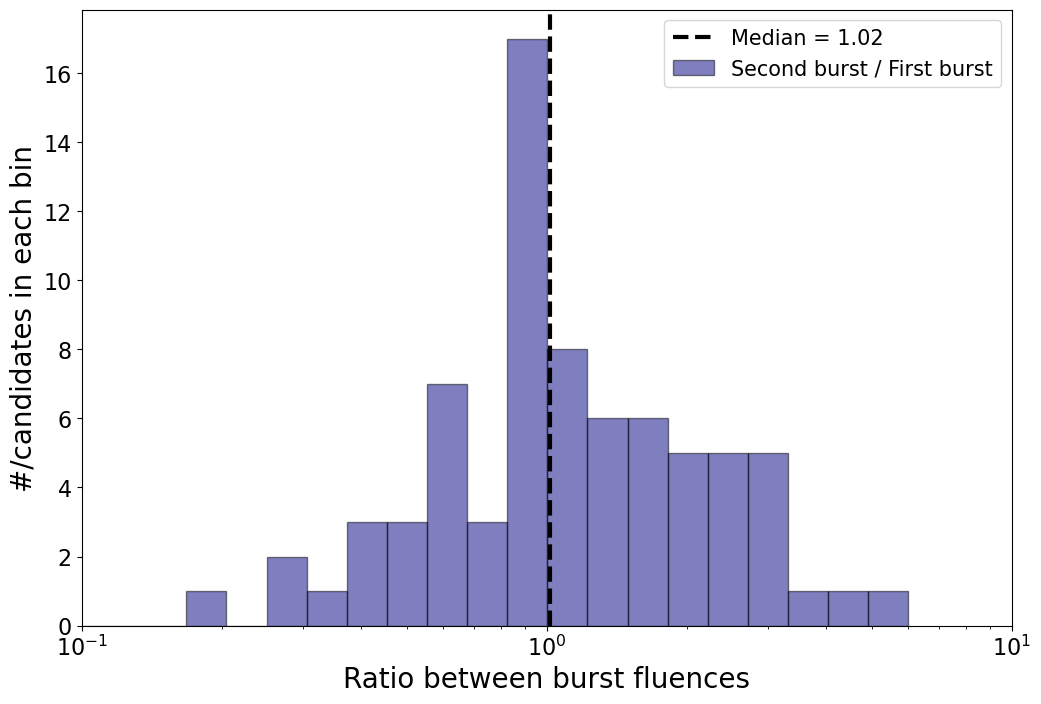

In [21]:
fig = plt.figure(figsize=(12, 8))

hist1, bins1 = np.histogram(np.array(first_burst_fluence)/np.array(second_burst_fluence), bins=23)
logbins = np.logspace(np.log10(bins1[0]),np.log10(np.ceil(bins1[-1])),len(bins1))

a= np.array(first_burst_fluence)
b= np.array(second_burst_fluence)
plt.hist(b/a, bins = logbins, edgecolor = 'black', color = 'navy', alpha = 0.5, label=r'Second burst / First burst')

plt.xscale('log')
plt.axvline(x=np.median(b/a), linestyle='--', c='k', linewidth =3, label='Median = {}'.format(np.round(np.median(b/a),2)))

plt.xlabel('Ratio between burst fluences', fontsize = 20)
plt.ylabel('#/candidates in each bin', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(prop={'size' : 15})
plt.xlim(0.1,10)
# plt.savefig('ratio_consecutive_burst_distribution.pdf', bbox_inches = 'tight')
plt.show()

In [22]:
wait_time = []
wait_time_59877 = []
wait_time_59879 = []
wait_time_59875 = []

# for all the observation days, calculate the time between the very first bursts and the rest of em
for i in range(len(np.unique(cand_ar))):
    if np.unique(cand_ar)[i] == '59877':
        wait_time_59877 = np.concatenate((wait_time_59877, np.array(sorted(full_time_in_seconds_for_each_candidate[i])-
               np.roll(sorted(full_time_in_seconds_for_each_candidate[i]), 1))[1:]))
    if np.unique(cand_ar)[i] == '59879':
        wait_time_59879 = np.concatenate((wait_time_59879, np.array(sorted(full_time_in_seconds_for_each_candidate[i])-
               np.roll(sorted(full_time_in_seconds_for_each_candidate[i]), 1))[1:]))
    if np.unique(cand_ar)[i] == '59875':
        wait_time_59875 = np.concatenate((wait_time_59875, np.array(sorted(full_time_in_seconds_for_each_candidate[i])-
               np.roll(sorted(full_time_in_seconds_for_each_candidate[i]), 1))[1:]))       
        
    wait_time = np.concatenate((wait_time, np.array(sorted(full_time_in_seconds_for_each_candidate[i])-
               np.roll(sorted(full_time_in_seconds_for_each_candidate[i]), 1))[1:]))

In [23]:
# some duplicate bursts still seeped through, remove em!
wait_time=np.delete(wait_time,np.argwhere(wait_time == 0))
wait_time_59875=np.delete(wait_time_59875,np.argwhere(wait_time_59875 == 0))

In [24]:
def Ppoisson(x, parm):
    R = parm[0]
    return (1 - np.exp(-x * R))

def PWeibull(x, parm):
    Rw = parm[0]
    k = parm[1]
    return (1 - np.exp(-(x * Rw * math.gamma(1+1/k))**k))

def fit_gaussian_to_dataset(dataset, bins, p0, name, plot=True):
    """ plots the data into rebinned bins
        fits and plots a straight power-law model to the rebinned data
        fits and plots a straight power-law model plus a gaussian line feature to the rebinned data
    :param dataset: the input data to be rebinned and fitted 
    :param location: a guess of the location of the gaussian line feature
    :return ml_cfpars: the MLEs of the parameters
    :return err: the errors on the MLE of the parameters
    :return minchisq_pl: the minimum chi-squared for the single power-law model
    :return minchisq_pl_gaus: the minimum chi-squared for the power-law + gaussian model
    """ 
    hist, bins, = np.histogram(dataset, bins=bins, density=False)
    logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
    counts, edges = np.histogram(dataset, bins=logbins, density=False)
    
    #rebin the data into different bins and counts
    mincounts = 3
    counts2, edges2 = histrebin(mincounts,counts,edges)
    energies = (edges2[:-1]+edges2[1:])/2.
    
    bwidths = np.diff(np.log(edges2)) 
    cdens = counts2/bwidths 
    cdens_err = np.sqrt(counts2)/bwidths 

    #fit the continuum power-law model plus the gaussian to the data
#     ml_cfpars, best_model, err, minchisq_pl,ebins,cdens,cdens_err,cdens_model = plot_fit(log_normal, [5, 1.4, 25000], {0:'Noise Offset', 1:'N0', 2:'Lambda'}, counts2, edges2, bwidths, cdens, cdens_err, energies, plot)    
    ml_cfpars, best_model, err, minchisq_pl,ebins,cdens,cdens_err,cdens_model, energies_of_points = plot_fit(double_log_normal, p0, {0:'Noise Offset', 1:'N0', 2:'Lambda'}, counts2, edges2, bwidths, cdens, cdens_err, energies, plot, name)    

    if len(ml_cfpars) > 4:
        return np.exp(ml_cfpars[0] - ml_cfpars[1]**2), np.exp(ml_cfpars[3] - ml_cfpars[4]**2), energies_of_points, cdens, cdens_err
    else:
         return np.exp(ml_cfpars[0] - ml_cfpars[1]**2), energies_of_points, cdens, cdens_err


def plot_spec_model(ebins,cdens,cdens_err,cdens_model, ml_cfpars, name):
    '''Plot the binned (GeV) spectrum with the model as a histogram, and 
       data/model residuals.
       Inputs:
           ebins - energy bin edges.
           cdens, cdens_err - counts density and its error.
           cdens_model - model counts density.'''
    
    color_list = ['blue', 'orange', 'green', 'red', 'yellow']
    energies = (ebins[1:]+ebins[:-1])/2
#     print(ml_cfpars)
    bwidths = np.diff(ebins)
    
    fig = plt.figure(figsize=(16, 16))
    rows=3
    cols=1
    widths = [1]
    heights = [1,3,1]

    gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

    ax1 = fig.add_subplot(gs[1,0])
    ax1.errorbar(energies, cdens, xerr=bwidths/2., yerr=cdens_err, fmt='.', label='Bin values', c = 'navy', alpha = 0.7)
    model_hist, edges, patches = ax1.hist(energies, bins=ebins, color='crimson', weights = cdens_model, density= False, histtype='step', label='Fit')

    minchisq = np.sum(((cdens-log_normal(energies,ml_cfpars))/cdens_err)**2)
    dof = len(energies)-len(ml_cfpars)

    print("Minimum Chi-squared = "+str(minchisq)+" for "+str(dof)+" d.o.f. should not exceed "+str(st.chi2.ppf(1-.05, df=dof)))
    print("The goodness of fit is: ",st.chi2.sf(minchisq,df=dof))
    print("Reduced Chi-squared= "+str(minchisq/dof)+" for "+str(dof)+" d.o.f")
    
    ax2 = fig.add_subplot(gs[2,0])
    ax2.errorbar(energies, cdens-cdens_model, xerr=bwidths/2., yerr=cdens_err, fmt='.', label ='Bin values', c = 'navy', alpha = 0.7)
    ax2.axhline(1.0, color='r', linestyle='dotted', lw=2) 
    ax1.tick_params(labelsize=14)
    ax2.set_xlabel('Wait time in seconds' , fontsize = 20)
    ax1.tick_params(axis="x",direction="in",which="both", length=4)
    ax2.tick_params(axis="x",which="both", length=4)
    ax1.set_ylabel('Normalised events/bin', fontsize = 20)
    ax2.set_ylabel('Data-model', fontsize = 15)
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax2.tick_params(labelsize=14)
    ax1.get_yaxis().set_label_coords(-0.12,0.5)
    ax2.get_yaxis().set_label_coords(-0.12,0.5)
    ax1.legend(prop={'size':15})
    ax1.axvline(x=np.exp(ml_cfpars[0] - ml_cfpars[1]**2), color = 'gray', linestyle='dashed', linewidth = 1)
    ax1.axvline(x=np.exp(ml_cfpars[3] - ml_cfpars[4]**2), color = 'gray', linestyle='dashed', linewidth = 1)
    ax1.text(1.1*np.exp(ml_cfpars[0] - ml_cfpars[1]**2), 70, str(np.round(np.exp(ml_cfpars[0] - ml_cfpars[1]**2),2))+' s', rotation='vertical', fontsize = 15, color = 'gray', alpha = 0.75)
    ax1.text(1.1*np.exp(ml_cfpars[3] - ml_cfpars[4]**2), 70, str(np.round(np.exp(ml_cfpars[3] - ml_cfpars[4]**2)*1000, 2))+' ms', rotation='vertical', fontsize = 15, color = 'gray', alpha = 0.75)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    
    x_cdf = np.array(sorted(wait_time[wait_time > 0.5]))
    y_cdf = np.array(range(1, len(sorted(wait_time[wait_time > 0.5]))+1))/637
    y_err = y_cdf*0.9
    
    p0 = [0.011]
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda x_cdf, *parm: model_int_cf(x_cdf, x_cdf, Ppoisson, *parm), x_cdf, y_cdf, p0)
    dof = len(x_cdf)-len(p0)

    ax3 = fig.add_subplot(gs[0,0], sharex=ax1)
    ax3.plot(x_cdf, Ppoisson(x_cdf, ml_cfpars), label='Poisson rate {} ± {} bursts/hr'.format(np.round(ml_cfpars[0]*3600,1), np.round(np.sqrt(np.diag(ml_cfcovar))[0]*3600,1)), c = 'crimson', alpha = 0.7)
    ax3.plot(x_cdf, y_cdf, c = 'navy', alpha = 0.7, drawstyle='steps', label='CDF wait times')
        
    p0 = [0.011, 1]
    ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda x_cdf, *parm: model_int_cf(x_cdf, x_cdf, PWeibull, *parm), x_cdf, y_cdf, p0)
    dof = len(x_cdf)-len(p0)
    
    ax3.plot(x_cdf, PWeibull(x_cdf, ml_cfpars), label='Weibull rate {} ± {} bursts/hr, k =  {} ± {}'.format(np.round(ml_cfpars[0]*3600,1), np.round(np.sqrt(np.diag(ml_cfcovar))[0]*3600,1), np.round(ml_cfpars[1],2), np.round(np.sqrt(np.diag(ml_cfcovar))[1],3)), c = 'crimson', alpha = 0.7)
        
    cdf1 = Ppoisson(x_cdf, ml_cfpars)  # Replace with your first CDF data
    cdf2 = y_cdf  # Replace with your second CDF data

    compare_cdfs(cdf1, cdf2, x_cdf)
    
    cdf1 = PWeibull(x_cdf, ml_cfpars)  # Replace with your first CDF data
    compare_cdfs(cdf1, cdf2, x_cdf)

    ax3.set_xscale('log')
    ax3.legend(prop={'size':15})
    ax3.tick_params(axis='both', which='major', labelsize=20)
    ax3.set_ylabel('Cumulative Density', fontsize = 15)
    ax1.yaxis.set_label_coords(-0.06,0.5)
    ax2.yaxis.set_label_coords(-0.06,0.5)
    ax3.yaxis.set_label_coords(-0.06,0.5)
    ax3.get_xaxis().set_visible(False)
#     plt.savefig('Waittimes_with_cdf.pdf', bbox_inches = 'tight')
    return energies, ml_cfcovar

[0.01661591842155342, 0.0019926224104053667, 81974589.31413074, 0.07760397718767169, 0.013579047120757066, 0.6128759542125781]
Minimum Chi-squared = 106.5961434823512 for 46 d.o.f. should not exceed 62.829620411408165
The goodness of fit is:  1.0286004708428192e-06
Reduced Chi-squared= 2.317307467007635 for 46 d.o.f
Kolmogorov-Smirnov test:
Statistic: 0.08675078864353312
P-value: 0.016901138193894025
Kolmogorov-Smirnov test:
Statistic: 0.04889589905362776
P-value: 0.4349073491381548


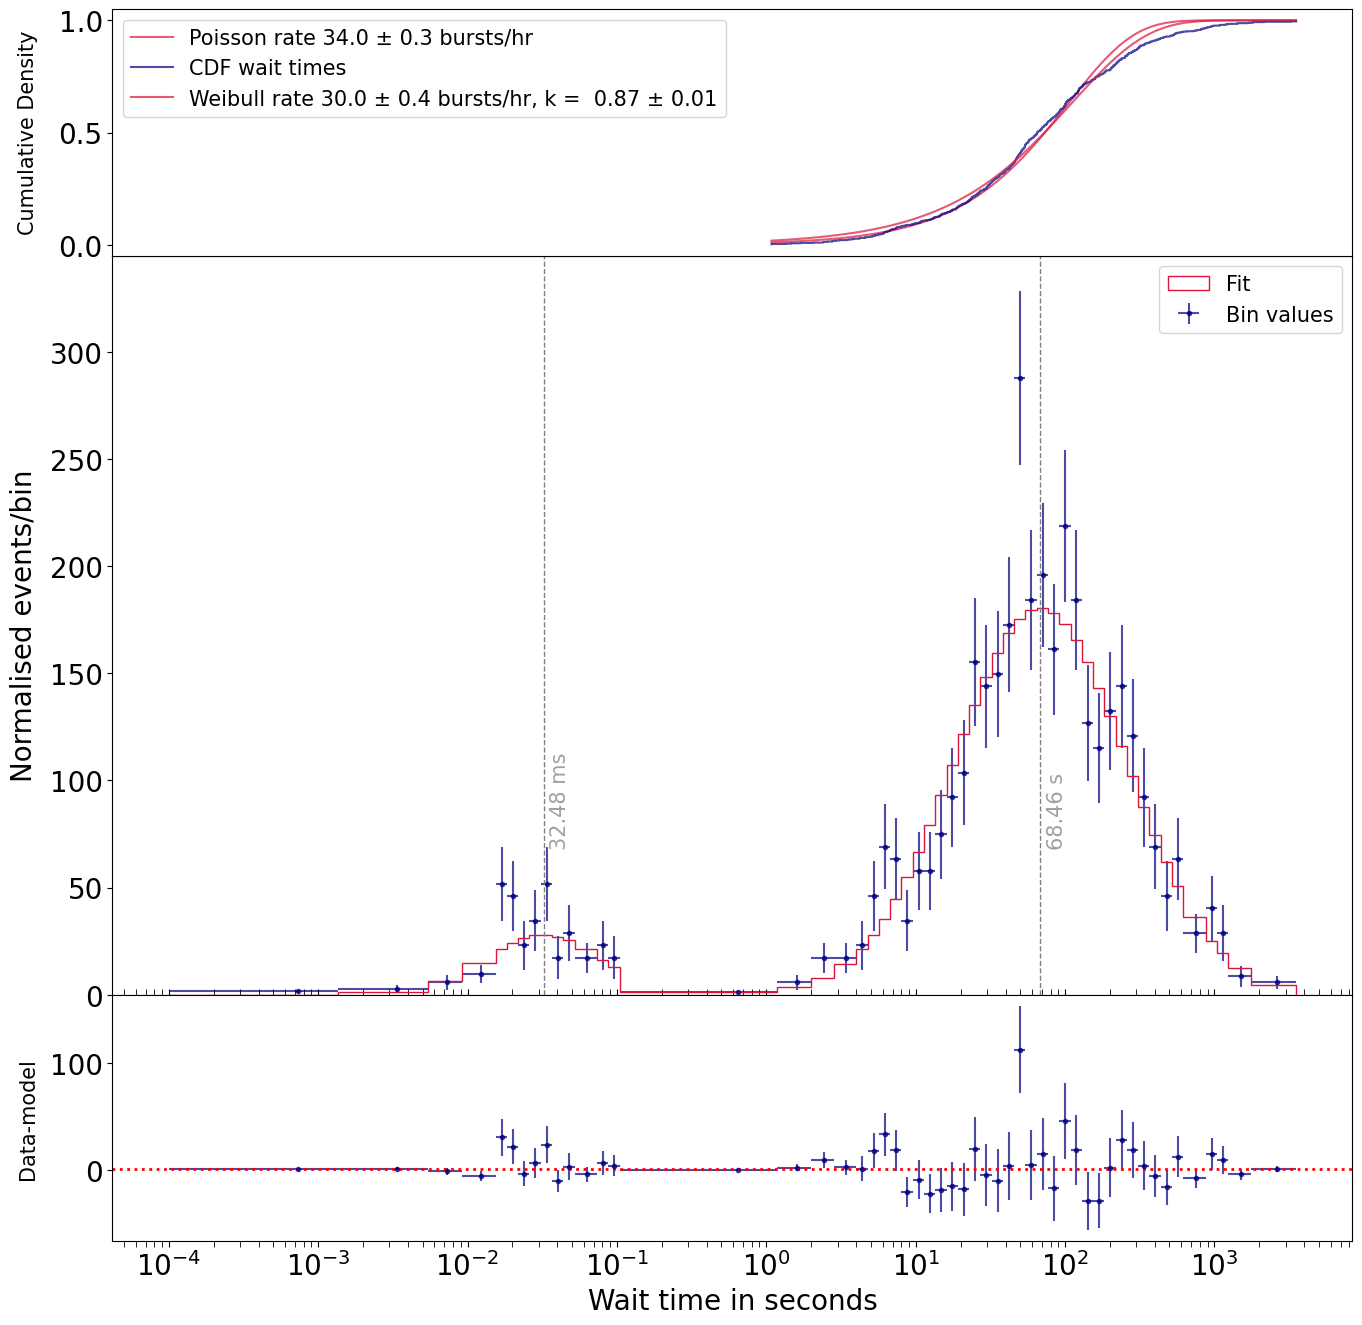

In [25]:
_ = fit_gaussian_to_dataset(np.array(wait_time), 100, [6, 1.3, 10000, -3, 0.85, 3], 'full', plot=True)

In [26]:
# _ = fit_gaussian_to_dataset(np.array(wait_time_59877), 20, [4.819927472810797, 1.0855827693109925, 4388.233118984369, 0.02869240289876889, -1.669642625869945, -1.9812352315520771], 'one_day', plot=True)

In [27]:
# _ = fit_gaussian_to_dataset(np.array(wait_time_59879), 20, [4.819927472810797, 1.0855827693109925, 4388.233118984369, 0.02869240289876889, -1.669642625869945, -1.9812352315520771], 'one_day', plot=True)

## Burst Rate

In [28]:
with open('Observation times.txt') as f:
    lines = f.readlines()

obs_dict = {}

#from all nancay observations, select all the R117 observations and their durations
for i in range(len(lines)):
    if lines[i].split('pc')[0].split(' ')[-1] == '219.5':
        mjd = lines[i].split('_')[1]
        obs_sec = float(lines[i].split(' ')[2])
        
        if mjd in np.unique(cand_ar):
            index_sorted_mjdlist = np.argwhere(np.unique(cand_ar) == mjd)[0][0]
            burst_rate = len(cand_ordered_full_ar[index_sorted_mjdlist])
            obs_dict[mjd] = [obs_sec, burst_rate]
        else: 
            obs_dict[mjd] = [obs_sec, 0]

In [29]:
burst_rate_dict = {}

#get the poissonian errors for all burst rates
for i in range(len(obs_dict.keys())):
    rate = np.array([np.array(list(obs_dict.values()))[:,1][i]])
    obs_dur_hour = np.array(list(obs_dict.values()))[:,0][i]/(60*60)
    if rate != 0:
        lower_lim, upper_lim = get_poisson_error(rate)
    else:
        lower_lim, upper_lim = get_poisson_error(rate, 1-(1-0.68)*2)
    burst_rate_dict[list(obs_dict.keys())[i]] = [rate[0]/obs_dur_hour, lower_lim[0]/obs_dur_hour, upper_lim[0]/obs_dur_hour]

In [30]:
mjd_array = np.array(sorted(burst_rate_dict.keys()), dtype=int)
obs_duration = np.flip(np.array(list(obs_dict.values()))[:,0])
rate_array = np.flip(np.array(list(burst_rate_dict.values()))[:,0])
rate_lower = np.flip(np.array(list(burst_rate_dict.values()))[:,1])
rate_upper = np.flip(np.array(list(burst_rate_dict.values()))[:,2])

for i in range(len(rate_array)):
    if rate_array[i] == 0:
        rate_lower[i]=rate_upper[i]

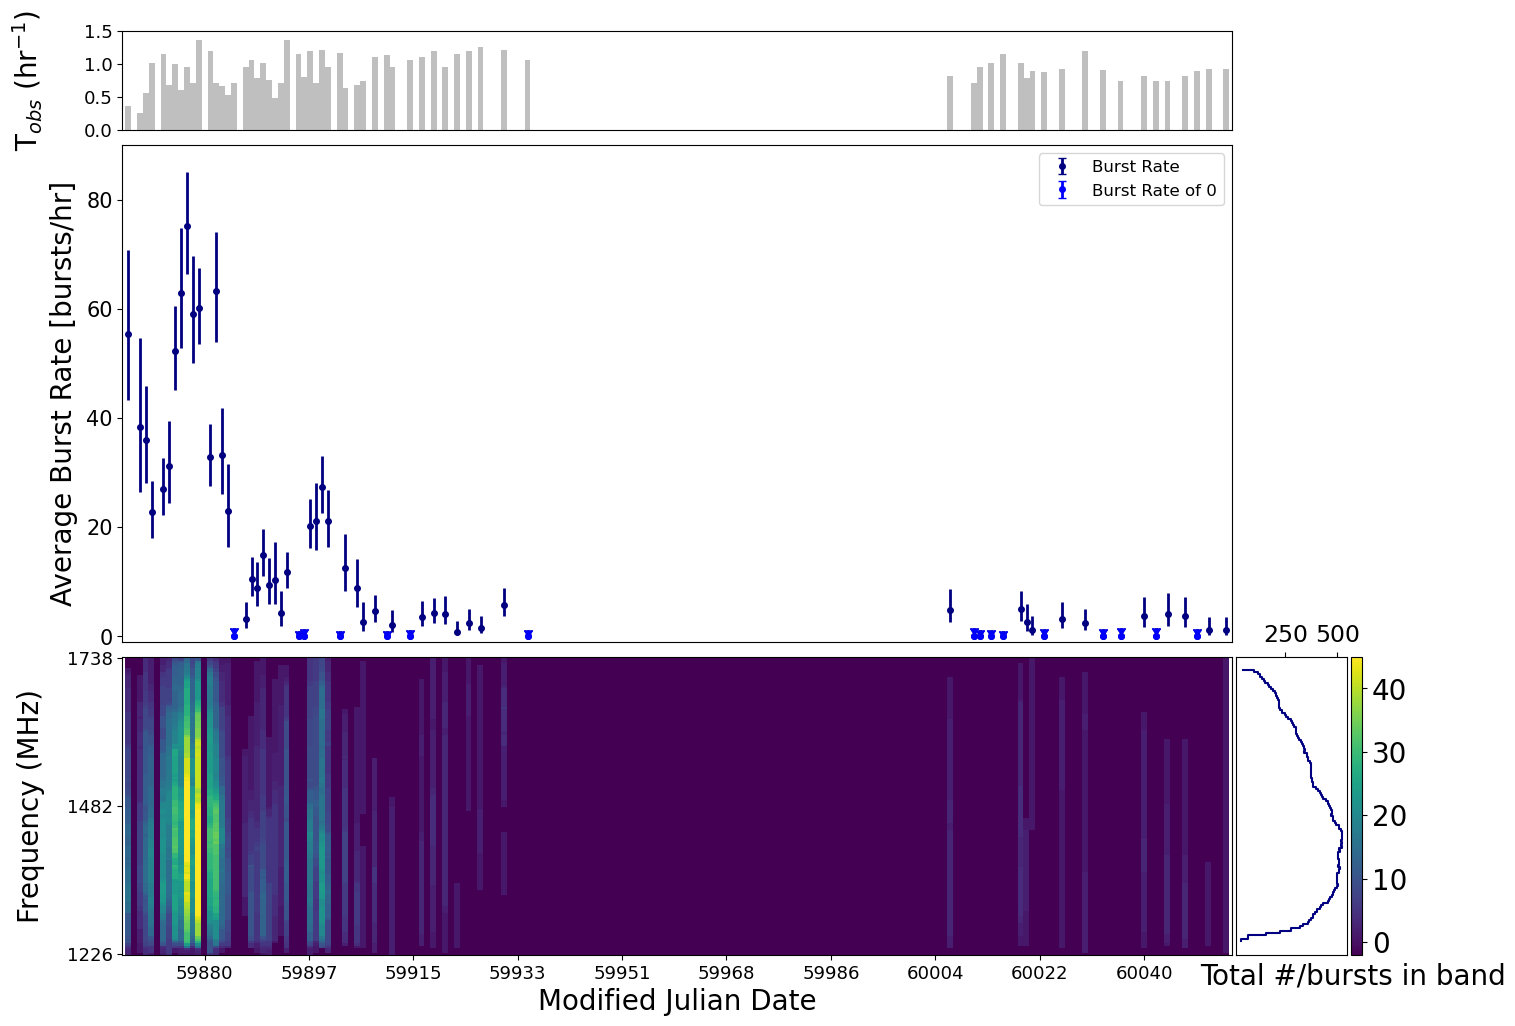

In [31]:
fig = plt.figure(figsize=(16, 12))
rows=3
cols=3
widths = [10,1,0.1]
heights = [1,5,3]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.01, hspace=0.05)

ax1 = fig.add_subplot(gs[2,0])
clb = ax1.imshow(np.flip(np.array(total_bursts_bws).T, axis = 0),cmap = 'viridis', vmin = -2, vmax = 45, aspect='auto',interpolation='None')
ax1.set_xlim(-1, 188)
ax1.set_xticks(np.linspace(13, 173, 10))
ax1.set_xticklabels(np.array(np.linspace(59880,60040, 10), int))
ax1.set_yticks(np.linspace(0, 128, 3))
ax1.set_yticklabels(np.array(np.linspace(1738, 1226, 3), int))
ax1.tick_params(axis='both', which='major', labelsize=13)
ax1.set_xlabel('Modified Julian Date', fontsize = 20)
ax1.set_ylabel('Frequency (MHz)', fontsize = 20)

ax2 = fig.add_subplot(gs[2,1])
ax2.plot(total_bw_bursts, np.linspace(0, 128 ,129), label='Bin values', c='navy', drawstyle='steps')
ax2.get_yaxis().set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=17)
ax2.xaxis.tick_top()
ax2.set_xlabel(('Total #/bursts in band'), fontsize = 20)
ax2.xaxis.set_label_coords(1.05, -0.025)

ax3 = fig.add_subplot(gs[1,0])
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.errorbar(mjd_array, rate_array, yerr=[rate_array-rate_lower, rate_upper-rate_array], uplims = rate_array == 0, zorder = 1, linewidth = 2, label='Burst Rate', markersize=4, fmt='o', color='navy')
ax3.errorbar(mjd_array[np.argwhere(rate_array==0)], rate_array[np.argwhere(rate_array==0)], [np.array(rate_array-rate_lower)[np.argwhere(rate_array==0)].T[0], np.array(rate_upper-rate_array)[np.argwhere(rate_array==0)].T[0]], uplims = True, zorder = 1, markersize=4, linewidth = 2, label='Burst Rate of 0', fmt='o', color='blue')
ax3.get_xaxis().set_visible(False)
ax3.set_xlabel('Modified Julian Data', fontsize = 20)
ax3.set_ylabel('Average Burst Rate [bursts/hr]', fontsize = 20)
ax3.set_ylim(-1, 90)
ax3.set_xlim(59866,60055)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.legend(prop={'size':12})

ax4 =  fig.add_subplot(gs[0,0], sharex=ax3)
ax4.bar(mjd_array, obs_duration/3600, width = 1, alpha = 0.5, color = 'gray', zorder=0, label='Observation Length')
ax4.tick_params(axis='both', which='major', labelsize=10)
ax4.set_ylabel(r'T$_{obs}$ (hr$^{-1}$)', fontsize = 20)
ax4.set_ylim(0,1)
ax4.set_yticks([0,0.5,1,1.5])
ax4.get_xaxis().set_visible(False)
ax4.tick_params(axis='both', which='major', labelsize=13)

ax4.yaxis.set_label_coords(-0.07,0.5)
ax3.yaxis.set_label_coords(-0.04,0.5)
ax1.yaxis.set_label_coords(-0.07,0.5)

ax5 = fig.add_subplot(gs[2,2])
cbar = fig.colorbar(clb, cax=ax5)
cbar.ax.tick_params(labelsize=20) 
# plt.savefig('blue_Burst rate vs MJD full.pdf', bbox_inches = 'tight')
plt.show()

### Burst Rate vs Energy

In [32]:
frb_fluence = []
bandwidth = []

for i in range(len(burst_csv[burst_csv['Real Burst'] == True])):
    frb_fluence.append(float(np.array(burst_csv[burst_csv['Real Burst'] == True]['fluence'])[i]))
    bandwidth.append(4*float(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])[i]))

In [33]:
fluence_Jys = (np.array(frb_fluence)*1e-3)
distance =  362.4
z = 0.0771
red_cor = 1 / (1 + z)**2

distance_lum_cm = 3.086e24*distance
energy_spec= fluence_Jys*4*np.pi*(distance_lum_cm**2)*1e-23*red_cor
energy_iso = energy_spec

In [34]:
np.unique(np.array(frb_time, dtype=int))

median_energies_per_obs = [[] for _ in range(len(np.unique(np.array(frb_time, dtype=int))))]
frb_median_list = []

for i in range(len(frb_time)):
    for j in range(len(np.unique(np.array(frb_time, dtype=int)))):
        if np.unique(np.array(frb_time, dtype=int))[j] == np.array(frb_time, dtype=int)[i]:
            median_energies_per_obs[j].append(energy_iso[i])
    
for i in range(len(median_energies_per_obs)):
    median_energies_per_obs[i] = np.median(median_energies_per_obs[i])
    
for i in range(len(cand_ordered_full_ar)):
    frb_median_list.append(np.average(np.array(cand_ordered_full_ar[i], dtype=float)))

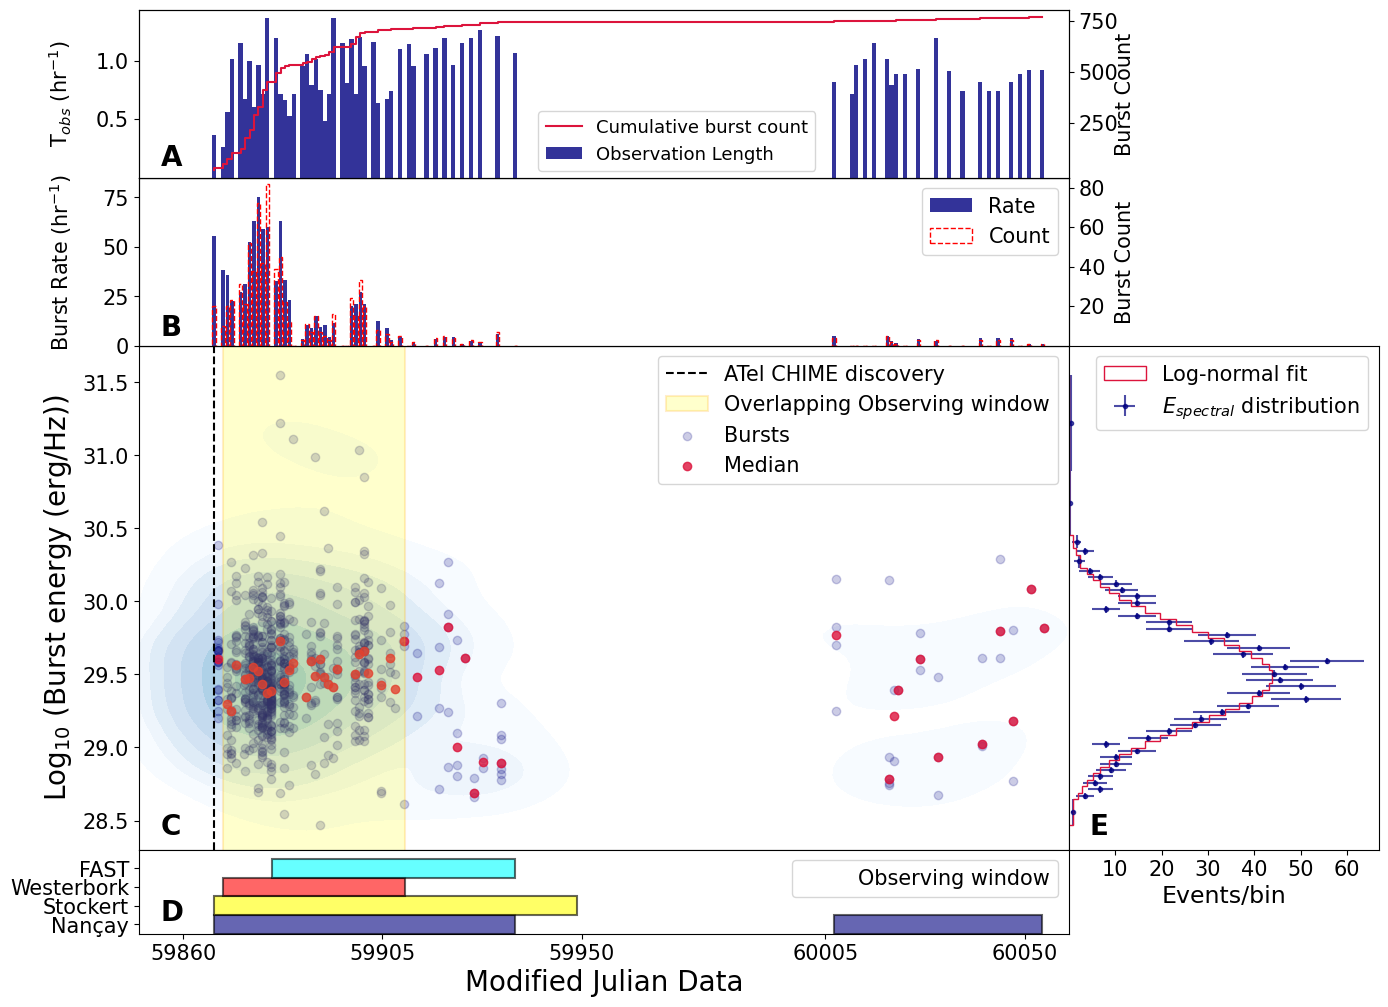

In [35]:
x = np.log10(abs(energy_iso))
y = frb_time
xmin, xmax = 28, 32
ymin, ymax = 59850, 60100

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)

nbins = 70
counts, edges = np.histogram(np.log10(abs(energy_iso)), bins=nbins, density=False)
#rebin the data into different bins and counts
mincounts = 3
counts2, edges2 = histrebin(mincounts,counts,edges)
bwidths = np.diff(edges2) 
cdens = counts2/bwidths 
cdens_err = np.sqrt(counts2)/bwidths 
energies = (edges2[:-1]+edges2[1:])/2.

bwidths = np.diff(edges2)

p0 = [30, 0.2, 401]
ml_cfpars, ml_cfcovar = spopt.curve_fit(lambda energies, *parm: model_int_cf(energies, edges2, normal, *parm), energies, cdens, p0, sigma=cdens_err)
best_model = model_int_cf(energies, edges2, normal, *ml_cfpars)

CDF_burst = []
counter = 0
for i in range(len(cand_ordered_full_ar)):
    counter += len(cand_ordered_full_ar[i])
    CDF_burst.append(counter)

fig = plt.figure(figsize=(16, 12))
rows=4
cols=2
widths = [3,1]
heights = [2,2,6,1]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

ax1 = fig.add_subplot(gs[2,0])
cfset = ax1.contourf(yy, xx, f, np.logspace(-3.5, -1, 10), norm=colors.LogNorm(vmin=1e-3, vmax=1e1), cmap='Blues')
ax1.scatter(frb_time, np.log10(abs(energy_iso)), alpha = 0.2, color ='navy', label='Bursts')
ax1.scatter(frb_median_list, np.log10(abs(np.array(median_energies_per_obs))), alpha = 0.8, color ='crimson', label='Median')
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel('Modified Julian Data', fontsize = 20)
ax1.set_ylabel(r'Log$_{10}$ (Burst energy (erg/Hz))', fontsize = 20)
ax1.set_xlim(ymin, ymax)
ax1.axvline(x=59867, linestyle='--', c='k', label="ATel CHIME discovery")
ax1.add_patch(Rectangle((59869, 28),59910-59869,4, linewidth=1.5, alpha = 0.2, label='Overlapping Observing window', fc ='yellow', color = 'orange'))

ax1.set_xticks([59860, 59905, 59950, 60005, 60050])
ax1.set_yticks([28.5,29,29.5,30,30.5,31,31.5])
leg = ax1.legend(prop={'size':15})
ax1.set_xlim(59850, 60060)
ax1.set_ylim(28.3,31.75)
ax1.yaxis.set_label_coords(-0.07,0.5)

ax2 = fig.add_subplot(gs[2,1], sharey=ax1)
model_hist, edges, patches = ax2.hist(energies, bins=edges2, weights = best_model, color = 'crimson', orientation=u'horizontal', density= False, histtype='step', label='Log-normal fit')
ax2.errorbar(cdens, energies, yerr=bwidths/2, xerr=cdens_err, fmt='.', label=r'$E_{spectral}$ distribution', color = 'navy', alpha = 0.7)
ax2.set_xlabel('Events/bin', fontsize = 17)
ax2.set_ylabel(r'Log$_{10}$ (Burst energy (erg/Hz))', fontsize = 20)
ax2.get_yaxis().set_visible(False)
ax2.legend(prop={'size':15})
ax2.set_xticks([200,400,600,800,1000,1200])
ax2.set_xticklabels(['10', '20', '30', '40', '50', '60'])
ax2.tick_params(axis='both', which='major', labelsize=15)

ax3 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3.bar(mjd_array, rate_array, zorder = 1, linewidth = 2, label='Rate', alpha = 0.8, color='navy')
ax3.bar(mjd_array, rate_array*(obs_duration/3600), facecolor='None', zorder = 1, linewidth = 1, label='Count', edgecolor='r', linestyle='--')
ax3.set_ylabel(r'Burst Rate (hr$^{-1}$)', fontsize = 15)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.set_ylim(0,85)
ax3.get_xaxis().set_visible(False)
ax3.yaxis.set_label_coords(-0.07,0.5)
leg = ax3.legend(prop={'size':15})
ax4 = ax3.twinx()
ax4.set_ylabel(r'Burst Count', fontsize = 15)
ax4.set_yticks([20, 40, 60, 80])
ax4.set_ylim([0, 85])
ax4.yaxis.set_label_coords(1.05,0.5)
ax4.tick_params(axis='both', which='major', labelsize=15)
ax5 = fig.add_subplot(gs[0,0], sharex=ax1)
ax5.bar(mjd_array, obs_duration/3600, width = 1, alpha = 0.8, color = 'navy', zorder=0, label='Observation Length')
ax5.plot(59910,0, drawstyle='steps', c='crimson', label='Cumulative burst count')
ax5.set_ylabel(r'T$_{obs}$ (hr$^{-1}$)', fontsize = 15)
ax5.tick_params(axis='both', which='major', labelsize=15)
ax5.get_xaxis().set_visible(False)
ax5.set_yticks([0.5, 1.00])
ax5.yaxis.set_label_coords(-0.07,0.5)
leg = ax5.legend(prop={'size':13}, bbox_to_anchor=(0.42,0.45))
ax6 = ax5.twinx()
ax6.set_ylabel(r'Burst Count', fontsize = 15)
ax6.plot(np.unique(np.array(frb_time, dtype=int)), CDF_burst, drawstyle='steps', c='crimson')
ax6.yaxis.set_label_coords(1.05,0.5)
ax6.tick_params(axis='both', which='major', labelsize=15)
ax6.set_yticks([250, 500, 750])

ax7 = fig.add_subplot(gs[3,0], sharex=ax1)
ax7.add_patch(Rectangle((59867, 0),59935-59867,1, linewidth=1.5, alpha = 0.6, fc ='navy', color = 'black'))
ax7.add_patch(Rectangle((60007, 0),60054-60007,1, linewidth=1.5, alpha = 0.6, fc ='navy', color = 'black'))
ax7.add_patch(Rectangle((59867, 1),59949-59867,1, linewidth=1.5, alpha = 0.6, fc ='yellow', color = 'black'))
ax7.add_patch(Rectangle((59869, 2),59910-59869,1, linewidth=1.5, alpha = 0.6, fc ='red', color = 'black'))
ax7.add_patch(Rectangle((59880, 3),59935-59880,1, linewidth=1.5, alpha = 0.6, fc ='cyan', color = 'black'))
ax7.add_patch(Rectangle((59880, 10),59935-59880,1, linewidth=1.5, alpha = 0.6, label='Observing window', fc ='white', color = 'white'))

ax7.set_ylim(0,4.5)
ax7.tick_params(axis='both', which='major', labelsize=15)
ax7.set_xlabel('Modified Julian Data', fontsize = 20)
ax7.set_xticks([59860, 59905, 59950, 60005, 60050])
ax7.legend(prop={'size' : 15})
ax7.set_yticks([0.5, 1.5, 2.5, 3.5])
ax7.set_yticklabels(['Nançay', 'Stockert', 'Westerbork', 'FAST'])

ax1.text(59855,28.4, 'C', fontsize = 20, weight='bold')
ax3.text(59855,5, 'B', fontsize = 20, weight='bold')
ax5.text(59855,0.1, 'A', fontsize = 20, weight='bold')
ax2.text(90,28.4, 'E', fontsize = 20, weight='bold')
ax7.text(59855,0.7, 'D', fontsize = 20, weight='bold')
# plt.savefig('full_burst_energy.pdf', bbox_inches = 'tight')
plt.show()

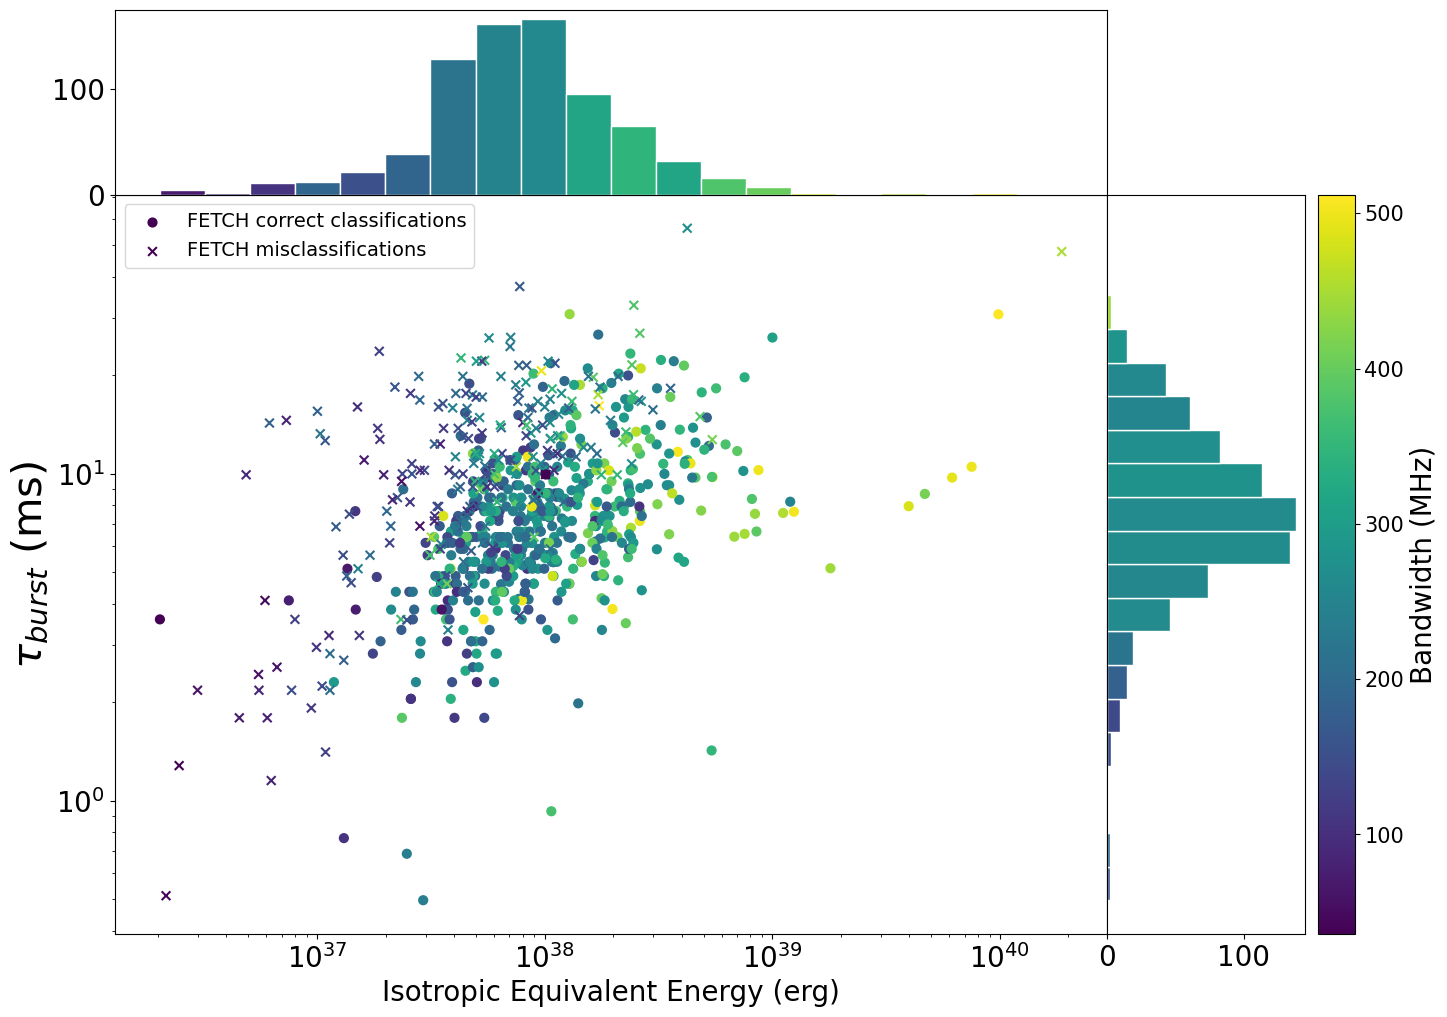

In [36]:
frb_fluence = []
bandwidth = []

for i in range(len(burst_csv[burst_csv['Real Burst'] == True])):
    frb_fluence.append(float(np.array(burst_csv[burst_csv['Real Burst'] == True]['fluence'])[i]))
    bandwidth.append(4*float(np.array(burst_csv[burst_csv['Real Burst'] == True]['freq width'])[i]))
    
fluence_Jys = (np.array(frb_fluence)*1e-3)
distance =  362.4
z = 0.0771
red_cor = 1 / (1 + z)**2

distance_lum_cm = 3.086e24*distance
energy_spec= fluence_Jys*4*np.pi*(distance_lum_cm**2)*1e-23
energy_iso = energy_spec
energy_iso = energy_spec * np.array(bandwidth)*1e6 
time_widths = burst_csv[burst_csv['Real Burst'] == True]['time width']*1.6e-2

fig= plt.figure(figsize=(16, 12))
rows=2
cols=2
widths = [4,1]
heights = [1,4]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)

ax1 = fig.add_subplot(gs[1,0])
clb = ax1.scatter(energy_iso[fetch_correct_list], time_widths[fetch_correct_list], c=dv_total[fetch_correct_list], s = 40,  marker = 'o')
ax1.scatter(energy_iso[fetch_miss_list], time_widths[fetch_miss_list], c=dv_total[fetch_miss_list], s = 40, marker = 'x')

ax1.scatter(1e38,10, c='#440154FF', s = 40,  marker = 'o', label='FETCH correct classifications')
ax1.scatter(1e38,10, c='#440154FF', s = 40, marker = 'x', label='FETCH misclassifications')

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlabel('Isotropic Equivalent Energy (erg)', fontsize = 20)
ax1.set_ylabel(r'$\tau_{burst}$ (ms)', fontsize = 30)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.legend(prop={'size':14})
hist, bins = np.histogram(energy_iso, bins=20)
logbins_energy = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

ax2 = fig.add_subplot(gs[0,0], sharex=ax1)

values, bins, patches = ax2.hist(energy_iso, logbins_energy, color= '#440154ff', edgecolor='white')

snr_bins = []
for j in range(len(bins)-1):
    snr_average = []
    for i in range(len(energy_iso)):
        if energy_iso[i] >= bins[j] and energy_iso[i] <= bins[j+1]:
            snr_average.append(bandwidth[i])
    if len(snr_average) == 0:
        snr_bins.append(100)
    else:
        snr_bins.append(np.median(snr_average))
        
snr_bins=np.array(snr_bins)
for c, p in zip(snr_bins/max(bandwidth), patches):
    plt.setp(p, 'facecolor', cm(c))

ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.get_xaxis().set_visible(False)

hist, bins = np.histogram(time_widths, bins=20)
logbins_time = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))

ax3 = fig.add_subplot(gs[1,1], sharey=ax1)
values, bins, patches = ax3.hist(time_widths, logbins_time, orientation='horizontal', color= '#440154ff', edgecolor='white')
time_widths = np.array(time_widths)

snr_bins = []
for j in range(len(bins)-1):
    snr_average = []
    for i in range(len(energy_iso)):
        if time_widths[i] >= bins[j] and time_widths[i] <= bins[j+1]:
            snr_average.append(bandwidth[i])
    if len(snr_average) == 0:
        snr_bins.append(100)
    else:
        snr_bins.append(np.median(snr_average))
        
snr_bins=np.array(snr_bins)
for c, p in zip(snr_bins/max(bandwidth), patches):
    plt.setp(p, 'facecolor', cm(c))
    
ax3.tick_params(axis='both', which='major', labelsize=20)
ax3.get_yaxis().set_visible(False)

cbar = fig.colorbar(clb)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_ylabel('Bandwidth (MHz)', size =20)
# plt.savefig('Timewidth vs Energy.pdf', bbox_inches = 'tight')
plt.show()

### CDF Rate vs Energy

In [37]:
fluence_df = load_df("burst_info_V1.pickle")
st_filter = ['B01-st', 'B02-st', 'B03-st', 'B04-st', 'B108-st', 'B112-st', 'B113-st', 'B114-st', 'B116-st','B129-st','B131-st']
fluences_window_st = fluence_df[~fluence_df['id'].isin(st_filter)]

cand_names = np.array(burst_csv.query('`Real Burst` == True')['cand name'])
nrt_filter = []

for i in range(len(cand_names)):
    if int(cand_names[i][14:19]) >= 59869 and int(cand_names[i][14:19]) <= 59910:
        nrt_filter.append(True)
    else:
        nrt_filter.append(False)

fluences_wb_arr = fluences_arrays(fluence_df, telescope='wb')
fluences_stk_arr = fluences_arrays(fluences_window_st, telescope='st')
fluences_tr_arr = fluences_arrays(fluence_df, telescope='tr')
fluences_nrt_arr = np.array(frb_fluence)[nrt_filter]

ob_time_wb = 196.58
ob_time_tr = 274.03 + 3.23
ob_time_st = 760.10

ob_time_wb_window = 185.72
ob_time_st_window = 567.4
ob_time_nrt_window = sum(np.array(list(obs_dict.values()))[31:-1][:,0])/3600

,id,fluence,telescope,burst-index
43,B01-st,42.160639,st,1
66,B02-st,24.260761,st,2
44,B03-st,29.733580,st,3
45,B04-st,11.796727,st,4
0,B05-tr,40.749134,tr,5
...,...,...,...,...
119,B114-st,144.907166,st,114
120,B116-st,16.770346,st,116
122,B129-st,46.150610,st,129
121,B131-st,375.073496,st,131


Calculating best minimal value for power law fit
[ 3.29414120e+18 -6.37174805e-01]
Bootstrapping, only using 21 points out of 24 points
Calculating best minimal value for power law fit
[ 4.14350743e+48 -1.61158655e+00]
Bootstrapping, only using 277 points out of 308 points
Calculating best minimal value for power law fit
[ 1.26226889e+53 -1.72281652e+00]
Bootstrapping, only using 17 points out of 19 points


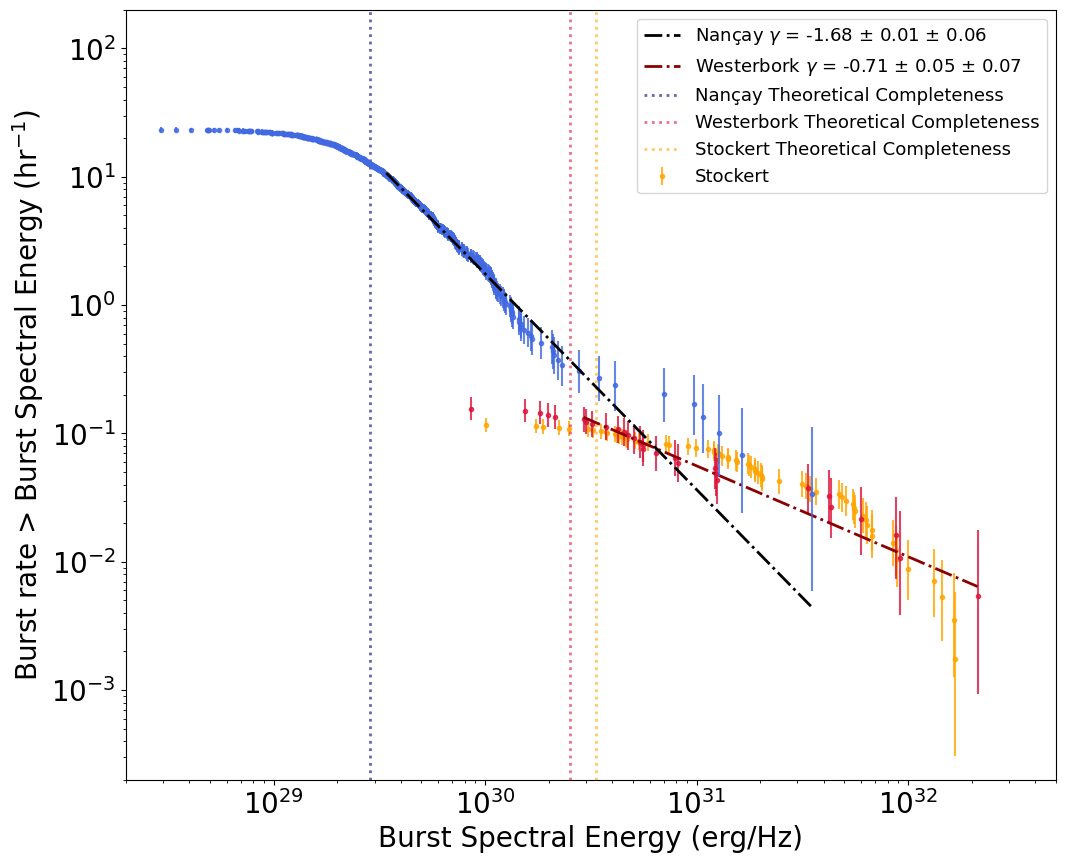

In [38]:
fig = plt.figure(figsize=(12, 10))

fluence_wb = fluence_limit()
fluence_wb_iso = isotropic_energies(fluence_wb)
fluence_nc = fluence_limit(sefd=35/1.4, bw=np.mean(burst_csv.query('`Real Burst` == True')['freq width'])*4, width = np.mean(burst_csv.query('`Real Burst` == True')['time width'])*1.6e-2, snr=20)
fluence_nc_iso = isotropic_energies(fluence_nc)
f_limit_stk = fluence_limit(sefd=385, width=3, bw=80, snr=15)
fluence_stk_iso = isotropic_energies(f_limit_stk)
fluence_array = [fluences_wb_arr, fluences_nrt_arr, fluences_stk_arr]
obs_array=[ob_time_wb_window, ob_time_nrt_window, ob_time_st_window]
colour_array=['crimson', 'royalblue','orange']
colour_fit_array=['darkred', 'black', 'orange']
scale_list=[1e18, 1e50, 1e60]
label_list = ['Westerbork', 'Nançay', 'Stockert']
zorder_list = [2,3,1]
    
for i in range(3):
    sorted_energy, cum_rate, sorted_energy_fit, sol2, sol2_err, boot_alpha, completeness_limit =\
            all_omar_knowledge(fluence_array[i], obs_array[i], scale_list[i])
    
    low_err = get_poisson_error(cum_rate*obs_array[i])[0]/obs_array[i]
    upp_err = get_poisson_error(cum_rate*obs_array[i])[1]/obs_array[i]
    
    plt.errorbar(sorted_energy, cum_rate, yerr = (cum_rate-low_err, upp_err-cum_rate), zorder = zorder_list[i], alpha = 0.8, color =colour_array[i],fmt='.', label=label_list[i])
    
    if i < 2:
        plt.plot(sorted_energy_fit, func_powerlaw(sorted_energy_fit, *sol2[0]), linewidth = 2, zorder = np.array(zorder_list[i])+0.5, linestyle='dashdot', c=colour_fit_array[i],\
             label = fr"{label_list[i]} $\gamma$ = {sol2[0][1]:.2f} $\pm$ {sol2_err[1]:.2f} $\pm$ {boot_alpha:.2f}")

plt.xlabel('Burst Spectral Energy (erg/Hz)', fontsize = 20)
plt.ylabel(r'Burst rate > Burst Spectral Energy (hr$^{-1}$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.axvline(fluence_stk_iso, linestyle='dotted', alpha = 0.6, lw=2,c='orange', label='Stockert Theoretical Completeness')
plt.axvline(fluence_wb_iso, linestyle='dotted', alpha = 0.6, lw=2,c='crimson', label='Westerbork Theoretical Completeness')
plt.axvline(fluence_nc_iso, linestyle='dotted', alpha = 0.6, lw=2,c='navy', label='Nançay Theoretical Completeness')
plt.xscale('log')
plt.yscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,4,3,2,7]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],prop={'size':13})
plt.xlim(2e28,5e32)
plt.ylim(2e-4, 2e2)
# plt.savefig('stk_CDF_burstrate-vs-fluence.png', bbox_inches = 'tight')
plt.show()

Calculating best minimal value for power law fit
[ 3.29414120e+18 -6.37174805e-01]
Bootstrapping, only using 21 points out of 24 points


100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 26995.52it/s]


Calculating best minimal value for power law fit
[ 4.14350743e+48 -1.61158655e+00]
Bootstrapping, only using 277 points out of 308 points


100%|█████████████████████████████████████████████████████████████████████████████| 687/687 [00:00<00:00, 28614.00it/s]


Calculating best minimal value for power law fit
[ 1.26226889e+53 -1.72281652e+00]
Bootstrapping, only using 17 points out of 19 points


100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 32002.32it/s]


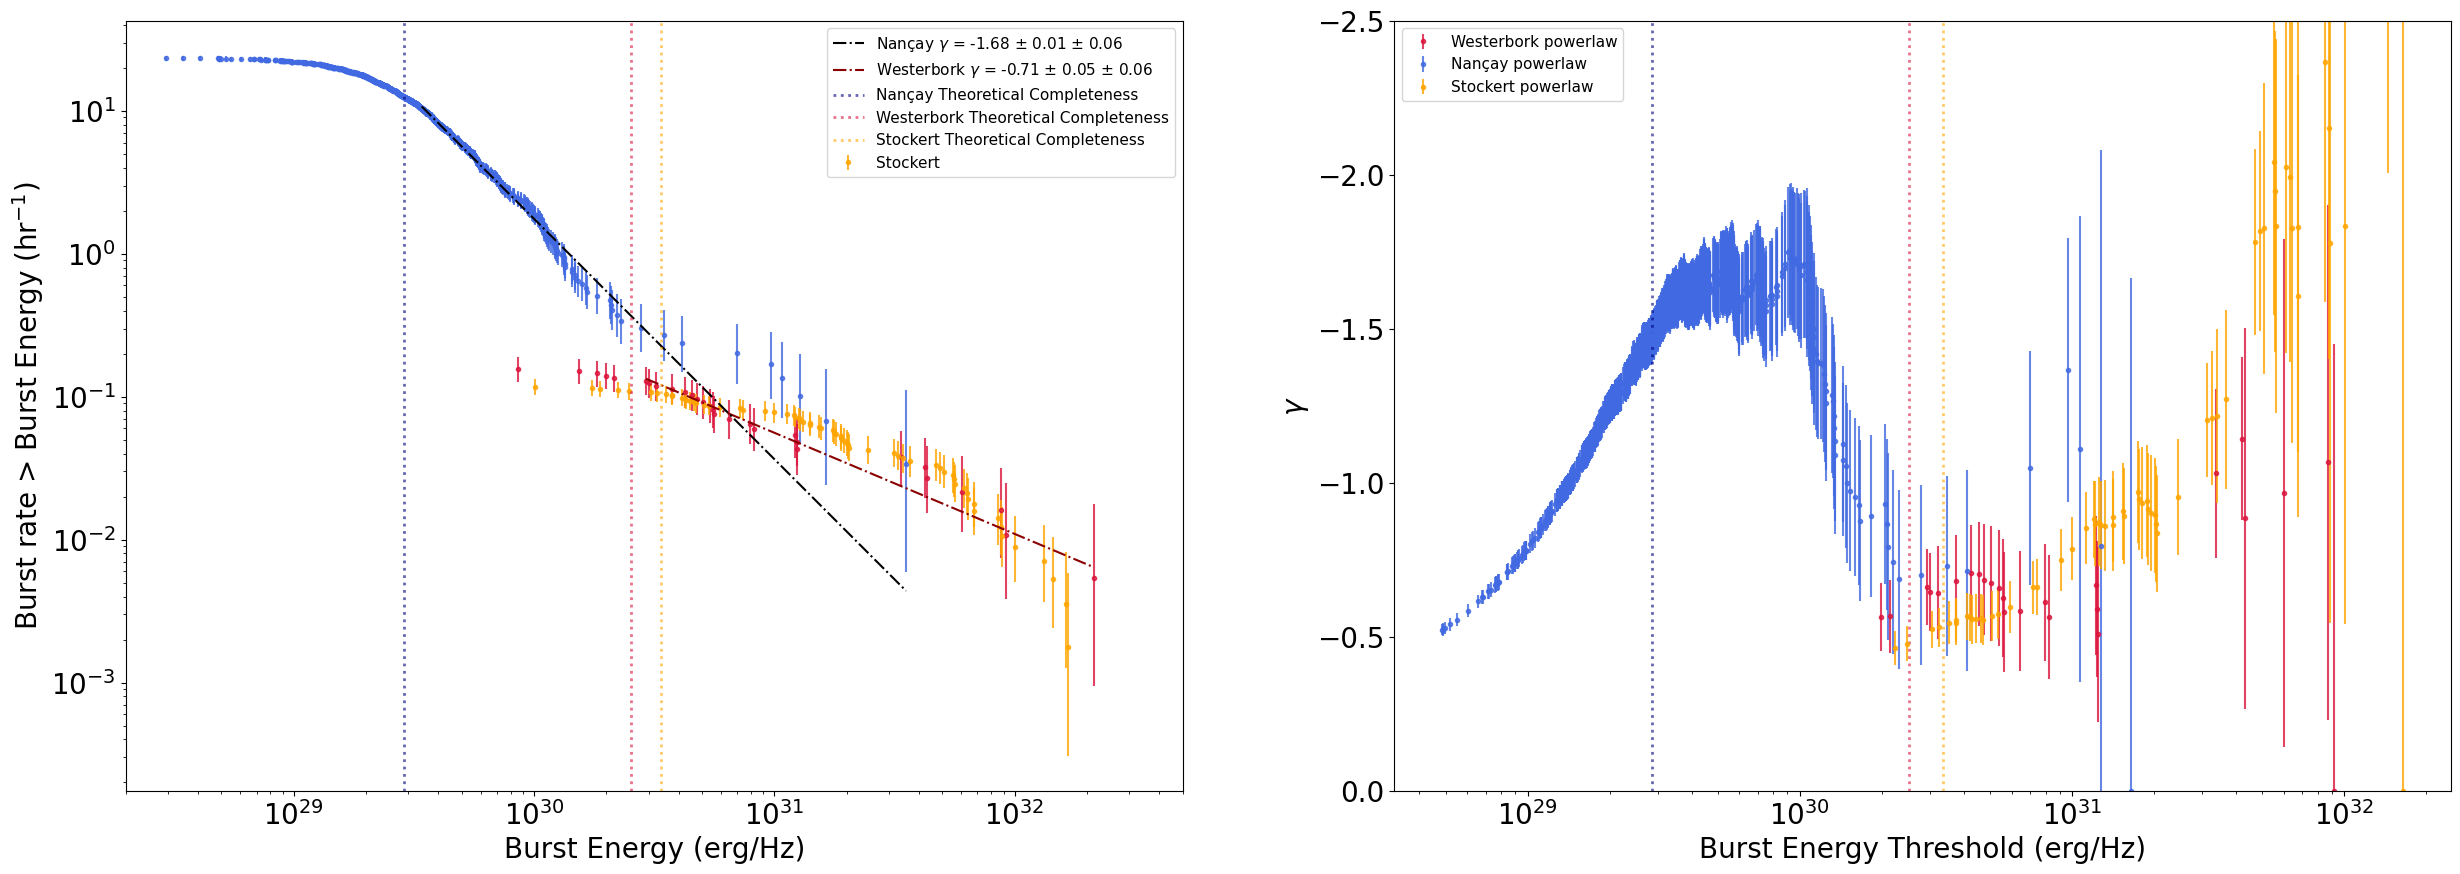

In [39]:
fig = plt.figure(figsize=(30, 10))
rows=1
cols=2
widths = [1,1]
heights = [1]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.2, hspace=0.0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for i in range(3):
    sorted_energy, cum_rate, sorted_energy_fit, sol2, sol2_err, boot_alpha, completeness_limit =\
            all_omar_knowledge(fluence_array[i], obs_array[i], scale_list[i])

    low_err = get_poisson_error(cum_rate*obs_array[i])[0]/obs_array[i]
    upp_err = get_poisson_error(cum_rate*obs_array[i])[1]/obs_array[i]
    ax1.errorbar(sorted_energy, cum_rate, yerr = (cum_rate-low_err, upp_err-cum_rate), alpha = 0.8, color =colour_array[i],fmt='.', zorder =0,label=label_list[i])

    if i < 2:
        ax1.plot(sorted_energy_fit, func_powerlaw(sorted_energy_fit, *sol2[0]), linestyle='dashdot', zorder = 1,c=colour_fit_array[i],\
             label = fr"{label_list[i]} $\gamma$ = {sol2[0][1]:.2f} $\pm$ {sol2_err[1]:.2f} $\pm$ {boot_alpha:.2f}")

    total_gamma = []
    energy_threshold = []
    error_ar = []
    
    for j in trange(1,len(sorted_energy)-1):
        alpha = (1/( -1/len(sorted_energy[sorted_energy>sorted_energy[j]]) * np.sum(np.log(sorted_energy[sorted_energy>sorted_energy[j]] / sorted_energy[j]))))
        M = len(sorted_energy[sorted_energy>sorted_energy[j]])
        alpha = ((M-1)/M) * alpha
        total_gamma.append(alpha)
        energy_threshold.append(sorted_energy[j])

        if M > 2:
            error = M * alpha / ((M-1)*(M-2)**0.5)
            error_ar.append(error)
        
    ax2.errorbar(energy_threshold[:-2], total_gamma[:-2], yerr = np.abs(error_ar), fmt='.', label = fr"{label_list[i]} powerlaw", color= colour_array[i], alpha = 0.8)

ax2.set_xscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel('Burst Energy Threshold (erg/Hz)', fontsize= 20)
ax2.set_ylabel(r'$\gamma$', fontsize= 20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim(-0.0, -2.5)
ax2.legend(prop={'size':11})

ax1.set_xlabel('Burst Energy (erg/Hz)', fontsize = 20)
ax1.set_ylabel(r'Burst rate > Burst Energy (hr$^{-1}$)', fontsize = 20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.axvline(fluence_stk_iso, linestyle='dotted', alpha = 0.6, lw=2,c='orange', label='Stockert Theoretical Completeness')
ax2.axvline(fluence_wb_iso, linestyle='dotted', alpha = 0.6, lw=2,c='crimson', label='Westerbork Theoretical Completeness')
ax2.axvline(fluence_nc_iso, linestyle='dotted', alpha = 0.6, lw=2,c='navy', label='Nançay Theoretical Completeness')
ax1.axvline(fluence_stk_iso, linestyle='dotted', alpha = 0.6, lw=2,c='orange', label='Stockert Theoretical Completeness')
ax1.axvline(fluence_wb_iso, linestyle='dotted', alpha = 0.6, lw=2,c='crimson', label='Westerbork Theoretical Completeness')
ax1.axvline(fluence_nc_iso, linestyle='dotted', alpha = 0.6, lw=2,c='navy', label='Nançay Theoretical Completeness')
ax1.set_xscale('log')
ax1.set_yscale('log')
handles, labels = ax1.get_legend_handles_labels()
order = [1,0,4,3,2,7]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order],prop={'size':11})
ax1.set_xlim(2e28,5e32)

# plt.savefig('Cumrate_and_powerlaw.png', bbox_inches = 'tight')
plt.show()

### Add FAST

In [40]:
fast_fluence_r117 = fast_r117(csv_file="FRB20220912A-Table.csv")

In [41]:
lll = np.array(burst_csv.query('`Real Burst` == True')['cand name'])
fast_observing_days_check = []

for i in range(len(lll)):
    if int(lll[i][14:19]) > 59880 and int(lll[i][14:19]) < 59935:
        fast_observing_days_check.append(True)
    else:
        fast_observing_days_check.append(False)

Calculating best minimal value for power law fit
[ 3.29414120e+18 -6.37174805e-01]
Bootstrapping, only using 21 points out of 24 points
Calculating best minimal value for power law fit
[ 4.14350743e+48 -1.61158655e+00]
Bootstrapping, only using 277 points out of 308 points
Calculating best minimal value for power law fit
[ 8.14291983e+64 -2.15498772e+00]
Bootstrapping, only using 53 points out of 59 points
Calculating best minimal value for power law fit
[ 1.26226889e+53 -1.72281652e+00]
Bootstrapping, only using 17 points out of 19 points


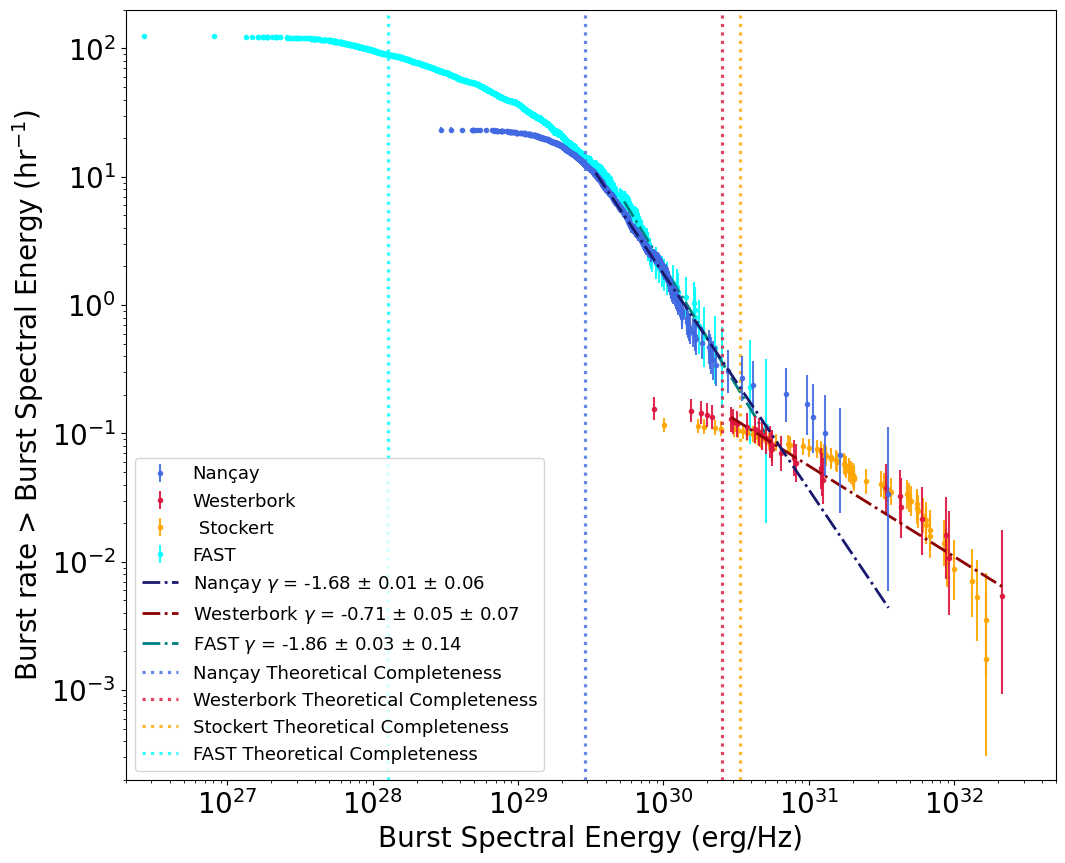

In [42]:
fig = plt.figure(figsize=(12, 10))

fluence_FAST = fluence_limit(sefd=18/16.1, bw=np.mean(burst_csv.query('`Real Burst` == True')['freq width'])*4, width = np.mean(burst_csv.query('`Real Burst` == True')['time width'])*1.6e-2, snr=20)
fluence_FAST_iso = isotropic_energies(fluence_FAST)

fluence_array = [fluences_wb_arr, fluences_nrt_arr, fast_fluence_r117, fluences_stk_arr]
obs_array=[ob_time_wb_window, ob_time_nrt_window, 8.67, ob_time_st_window]
colour_array=['crimson', 'royalblue','cyan','orange']
colour_fit_array=['darkred', 'midnightblue', 'teal','goldenrod']
scale_list=[1e18, 1e50, 1e60, 1e60]
label_list = ['Westerbork', 'Nançay', 'FAST', ' Stockert']
zorder_list = [2,3,0,1]
    
for i in range(4):
    sorted_energy, cum_rate, sorted_energy_fit, sol2, sol2_err, boot_alpha, completeness_limit =\
            all_omar_knowledge(fluence_array[i], obs_array[i], scale_list[i])
    
    low_err = get_poisson_error(cum_rate*obs_array[i])[0]/obs_array[i]
    upp_err = get_poisson_error(cum_rate*obs_array[i])[1]/obs_array[i]
        
    plt.errorbar(sorted_energy, cum_rate, yerr = (cum_rate-low_err, upp_err-cum_rate), zorder = zorder_list[i], alpha = 0.9, color =colour_array[i],fmt='.', label=label_list[i])
    
    if i < 3:
        plt.plot(sorted_energy_fit, func_powerlaw(sorted_energy_fit, *sol2[0]), linewidth = 2, zorder = np.array(zorder_list[i])+0.5, linestyle='dashdot', c=colour_fit_array[i],\
             label = fr"{label_list[i]} $\gamma$ = {sol2[0][1]:.2f} $\pm$ {sol2_err[1]:.2f} $\pm$ {boot_alpha:.2f}")

plt.xlabel('Burst Spectral Energy (erg/Hz)', fontsize = 20)
plt.ylabel(r'Burst rate > Burst Spectral Energy (hr$^{-1}$)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.axvline(fluence_stk_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='orange', label='Stockert Theoretical Completeness')
plt.axvline(fluence_wb_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='crimson', label='Westerbork Theoretical Completeness')
plt.axvline(fluence_nc_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='royalblue', label='Nançay Theoretical Completeness')
plt.axvline(fluence_FAST_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='cyan', label='FAST Theoretical Completeness')

plt.xscale('log')
plt.yscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
order = [8,7,10,9,1,0,2,5,4,3,6]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],prop={'size':13})
plt.xlim(2e26,5e32)
plt.ylim(2e-4, 2e2)
# plt.savefig('all_telescopes_cumrate.pdf', bbox_inches = 'tight')
plt.show()

Calculating best minimal value for power law fit
[ 3.29414120e+18 -6.37174805e-01]
Bootstrapping, only using 21 points out of 24 points


100%|███████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 27209.56it/s]


Calculating best minimal value for power law fit
[ 4.14350743e+48 -1.61158655e+00]
Bootstrapping, only using 277 points out of 308 points


100%|█████████████████████████████████████████████████████████████████████████████| 687/687 [00:00<00:00, 27489.60it/s]


Calculating best minimal value for power law fit
[ 8.14291983e+64 -2.15498772e+00]
Bootstrapping, only using 53 points out of 59 points


100%|███████████████████████████████████████████████████████████████████████████| 1074/1074 [00:00<00:00, 24976.62it/s]


Calculating best minimal value for power law fit
[ 1.26226889e+53 -1.72281652e+00]
Bootstrapping, only using 17 points out of 19 points


100%|███████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 32013.77it/s]


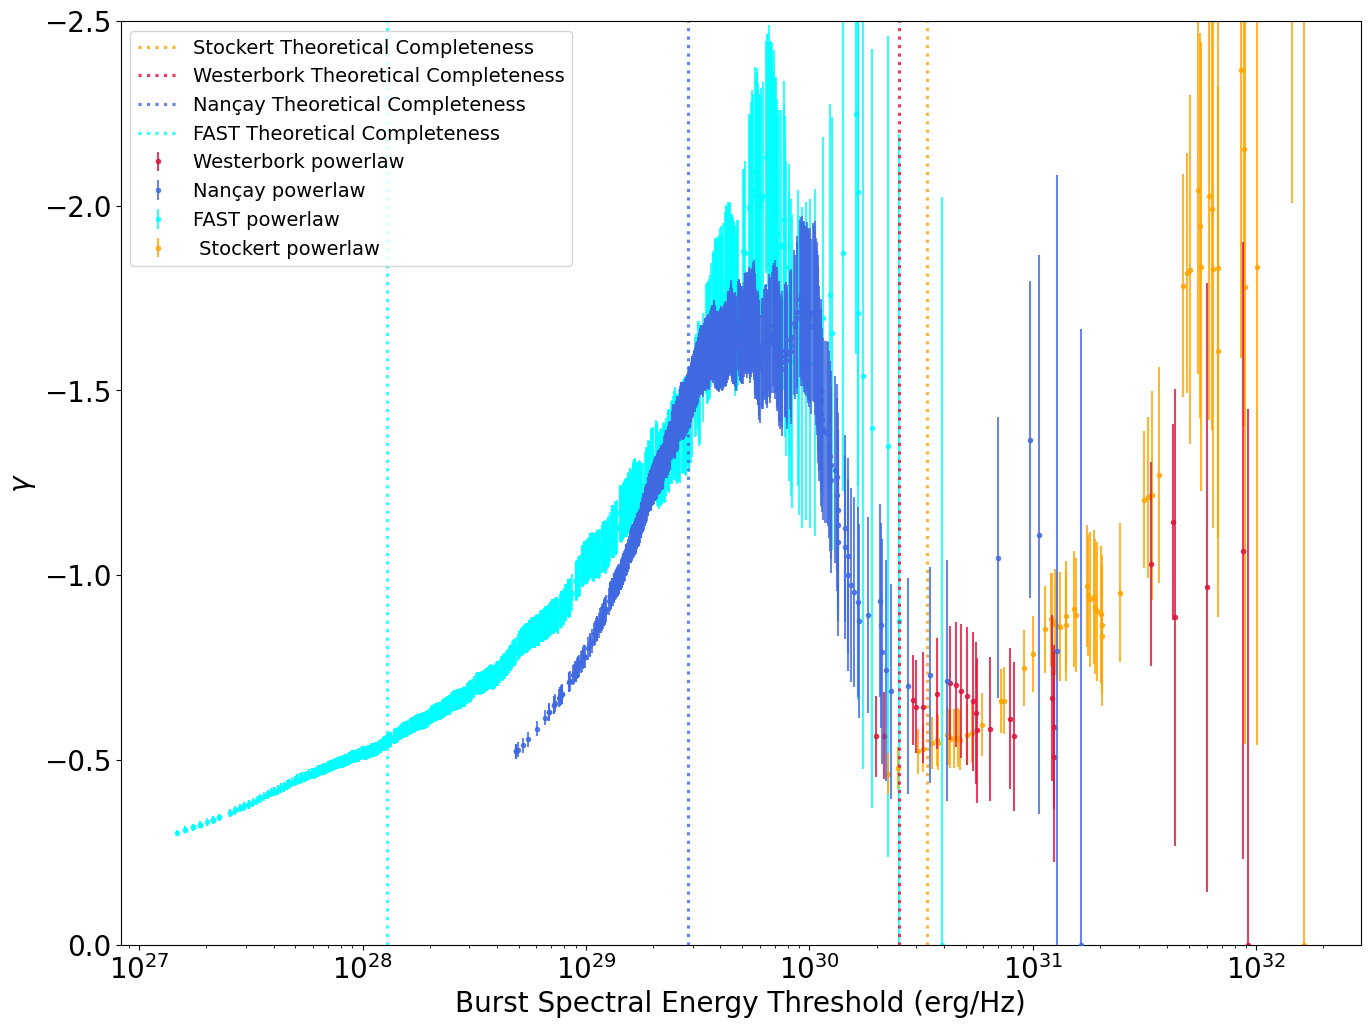

In [43]:
fig = plt.figure(figsize=(16, 12))
rows=1
cols=1
widths = [1]
heights = [1]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.2, hspace=0.0)

ax2 = fig.add_subplot(gs[0,0])

for i in range(4):
    sorted_energy, cum_rate, sorted_energy_fit, sol2, sol2_err, boot_alpha, completeness_limit =\
            all_omar_knowledge(fluence_array[i], obs_array[i], scale_list[i])

    total_gamma = []
    energy_threshold = []
    error_ar = []
    
    for j in trange(1,len(sorted_energy)-1):
        alpha = (1/( -1/len(sorted_energy[sorted_energy>sorted_energy[j]]) * np.sum(np.log(sorted_energy[sorted_energy>sorted_energy[j]] / sorted_energy[j]))))
        M = len(sorted_energy[sorted_energy>sorted_energy[j]])
        alpha = ((M-1)/M) * alpha
        total_gamma.append(alpha)
        energy_threshold.append(sorted_energy[j])

        if M > 2:
            error = M * alpha / ((M-1)*(M-2)**0.5)
            error_ar.append(error)
        
    ax2.errorbar(energy_threshold[:-2], total_gamma[:-2], yerr = np.abs(error_ar), zorder = zorder_list[i],fmt='.', label = fr"{label_list[i]} powerlaw", color= colour_array[i], alpha = 0.8)

ax2.axvline(fluence_stk_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='orange', label='Stockert Theoretical Completeness')
ax2.axvline(fluence_wb_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='crimson', label='Westerbork Theoretical Completeness')
ax2.axvline(fluence_nc_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='royalblue', label='Nançay Theoretical Completeness')
ax2.axvline(fluence_FAST_iso, linestyle='dotted', alpha = 0.8, lw=2.3,c='cyan', label='FAST Theoretical Completeness')

ax2.set_xscale('log')
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.set_xlabel('Burst Spectral Energy Threshold (erg/Hz)', fontsize= 20)
ax2.set_ylabel(r'$\gamma$', fontsize= 20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.set_ylim(-0.0, -2.5)
ax2.legend(prop={'size':14})

handles, labels = ax1.get_legend_handles_labels()
order = [4,2,0,5,3,1]

# plt.savefig('all_telescopes_powerlaw.pdf', bbox_inches = 'tight')
plt.show()

## Fetch missclassifications based on isotropic energies

<ipython-input-44-8ef424881db6>:20: RuntimeWarning: invalid value encountered in true_divide
  ylist = ydata_fetch/ydata_catch


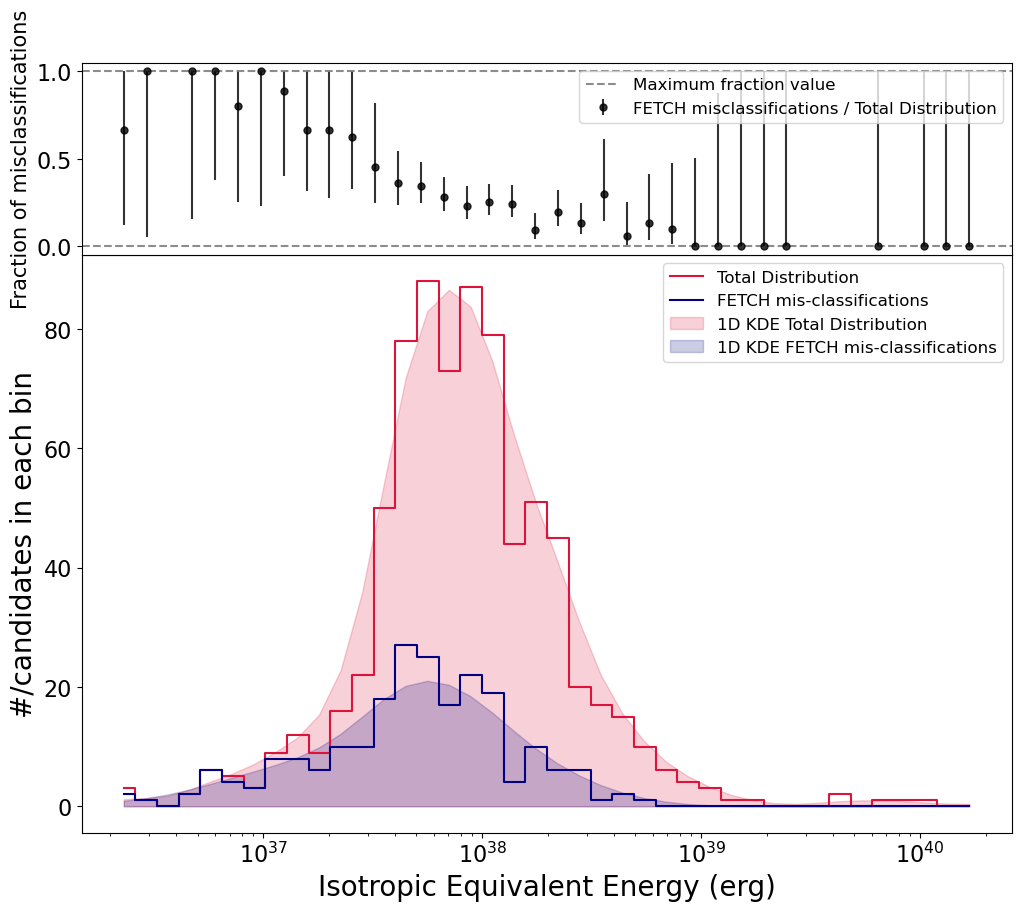

In [44]:
xdata_catch, ydata_catch, x_kde_catch, y_kde_catch, bins = kde_applied(energy_iso)
xdata_fetch, ydata_fetch, x_kde_fetch, y_kde_fetch, bins = kde_applied(energy_iso[fetch_miss_list], bins)

fig = plt.figure(figsize=(12, 10))
rows=2
cols=1
widths = [1]
heights = [1,3]

gs = gridspec.GridSpec(ncols=cols, nrows=rows,width_ratios=widths, height_ratios=heights, wspace=0.0, hspace=0.0)
ax = fig.add_subplot(gs[1,0])

ax.fill_between(((10**x_kde_catch).T)[0], np.zeros(len(y_kde_catch)), y_kde_catch, color='crimson', alpha = 0.2, label = '1D KDE Total Distribution')   
ax.plot(10**xdata_catch, ydata_catch, drawstyle='steps-mid', color='crimson', label = 'Total Distribution')
ax.fill_between(((10**x_kde_fetch).T)[0],np.zeros(len(y_kde_catch)), y_kde_fetch, color='navy', alpha = 0.2, label = '1D KDE FETCH mis-classifications')   
ax.plot(10**xdata_fetch, ydata_fetch, drawstyle='steps-mid', color='navy', label = 'FETCH mis-classifications')   


xlist = 10**xdata_catch
ylist = ydata_fetch/ydata_catch
fetch_lower, fetch_upper = get_poisson_error(ydata_fetch)
total_lower, total_upper = get_poisson_error(ydata_catch)
yerr_lower = []
yerr_higher = [] 

for i in range(len(ydata_fetch)):
    if total_lower[i] == 0:
        yerr_lower.append(np.nan)
        yerr_higher.append(np.nan)
    else:
        if fetch_upper[i]/total_lower[i] > 1:
            yerr_higher.append(1)
        else:
            yerr_higher.append(fetch_upper[i]/total_lower[i])
        yerr_lower.append(fetch_lower[i]/ total_upper[i])
        
yerr = (y_kde_fetch/y_kde_catch) * ((np.sqrt(y_kde_fetch)/y_kde_fetch)**2+(np.sqrt(y_kde_catch)/y_kde_catch)**2)**0.5

ax2 = fig.add_subplot(gs[0,0])
ax2.errorbar(xlist, ylist, yerr = (ylist-yerr_lower, yerr_higher-ylist) ,alpha = 0.8, markersize=10, fmt='.', c='k', label='FETCH misclassifications / Total Distribution')
ax2.set_ylabel('Fraction of misclassifications', fontsize = 15)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xscale('log')
ax2.get_xaxis().set_visible(False)
ax2.set_ylim(-0.05,1.05)
ax2.axhline(y=1, linestyle='dashed', c='grey', alpha = 0.9, label='Maximum fraction value')
ax2.axhline(y=0, linestyle='dashed', c='grey', alpha = 0.9)
ax2.legend(prop={'size' : 12}, loc=1)
ax.set_xlabel('Isotropic Equivalent Energy (erg)', fontsize = 20)
ax.set_ylabel('#/candidates in each bin', fontsize = 20)
ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(prop={'size' : 12})
# plt.savefig('FETCH misclassifications based on Iso energies.png', bbox_inches = 'tight')
plt.show()